## IMPORTANT: this file is based on having data parsed and saved by the file Download_data_Habit.ipynb

### Notes:
* 106 did not get to the manipulations on day 5 (still_valued_post_deval)! But I have their data here.
* 109, 112, 113, 114 did not pass consumption test
* (101, 102, 108 did not pass consumption test but the opposite: no slips, maybe thought it is not applied...)

## General settings

In [27]:
#@title Import stuff and general settings
import numpy as np
import pandas as pd
import collections
import firebase_admin
from firebase_admin import credentials, firestore
import math
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

import dateutil.parser
import pytz
from datetime import datetime, timedelta
from scipy import stats

# Helps make csv like string data to dataframe: (taken from https://stackoverflow.com/questions/22604564/create-pandas-dataframe-from-a-string):
import sys
if sys.version_info[0] < 3:
    from StringIO import StringIO
else:
    from io import StringIO


## Run this to enable data reading

In [2]:
#@title Parameter definition { form-width: "5%" }
# get this jupyter notebook path:

# database variables:
collection_name = 'tasks'
document_name = 'IDCH'
sub_collection = 'subjects'

manual_only_keep = [701, 702, 703, 104, 805, 106, 107, 108, 809, 110, 112, 813, 714] # 11 did not run yet..
mapping_to_real_num = {str(x): 100+x%100 for x in manual_only_keep}
manual_exclusions = [] # example:[705, 706]
doNotExcludedDueToMissingDays = [] # participants not to exclude due to missing days
doNotExcludedDueToNotSatisfyingMinDailyEntries = [] # participants not satisfying the minimum amount of daily entries

# paths:
main_path = os.getcwd()
# Raw data file names:
rawDataFileName = os.path.join(main_path, 'data/extracted_data/raw_data.json')
rawDataAsListFile = 'raw_data.txt'
rawDataAsBinaryFile = "raw_data.pkl"
# Parsed data filenames:
filteredDF_File = os.path.join(main_path, 'data/extracted_data/filteredDF.csv')
allDataFor_R_File = os.path.join(main_path, 'data/extracted_data/all_data_for_R.csv')
coreDataFileName = '/data/extracted_data/core_table.csv'


main_manipulation_days = {
    'short_training': {'still_valued': 3, 'devaluation': 4, 'still_valued_post_deval': 5},
    # 'long_training': {'still_valued': 9, 'devaluation': 10, 'still_valued_post_deval': 11},
    # 'long_training_parallel_manipulations': {'still_valued': 9, 'devaluation': 10, 'still_valued_post_deval': 11},  
}
manipulations_renamed = {
    'short_training': ['still_valued', 'devaluation', 'still_valued_post_deval'],
    # 'long_training': ['still_valued', 'devaluation', 'still_valued_post_deval'],
    # 'long_training_parallel_manipulations': ['still_valued_week1', 'still_valued_replacing_devaluation', 'still_valued_post_deval_week1', 'still_valued', 'devaluation', 'still_valued_post_deval'],  
}
all_manipulation_days = {
    'short_training': {'still_valued': 3, 'devaluation': 4, 'still_valued_post_deval': 5},
    # 'long_training': {'still_valued': 9, 'devaluation': 10, 'still_valued_post_deval': 11},
    # 'long_training_parallel_manipulations': {'still_valued_week1': 2, 'still_valued_replacing_devaluation': 3, 'still_valued_post_deval_week1': 4, 'still_valued': 9, 'devaluation': 10, 'still_valued_post_deval': 11},  
}


# payment table of the payment per final stage recorded:
timeToPayForTable = {
    'endTime': 10,
    'outcomeTime': 9,
    'press2Time': 2,
    'press1Time': 1.5,
    'startTime': 1,
}

# payment in USD:
hourlyFee = 20
paymentPerSecond = hourlyFee/60/60
constantPaymentInstructions = 15 # Payment for instructions + questionnairs + 2-step task
ConstantPaymentPostExperimentTasks = 35
twoStepTaskBonus = 3

# reward and cost
goldUnitsPerPiece = 20
costPerEntry = 3
costPerPressInConsumptionTest = 10

# number of experimental days by group:
n_experimental_days = 5

minimumDailyEntriesRequired = 5

n_manipulations = 3

# lines to remove in data:
signals_to_remove_data_lines = {
    'opennedInstallaitonPage': True,
    'showInstructions': True,
    'instructionsStartedFlag': True,
    'isDemo': True
}

dailyOffsetHours = 5 # the time past midnight that is included in the same day (5 means until 5:00 AM is considered the last day)
localTimeZone = "America/Los_Angeles" # used to adjust the time variables which are recorded in utc time.
timeInStringColumns = ['startTime', 'press1Time', 'press2Time', 'outcomeTime', 'endTime', 'userExitOrUnloadTime',
                       'realGameBeginsAlertTime', 'realGameBeginsConfirmationTime', 'resetContainerAlertTime', 'resetContainerConfirmationTime', 'manipulationAlertTime', 'manipulationConfirmationTime', 'foundCaveAlertTime', 'foundCaveConfirmationTime', 'endExperimentAlertTime'] # these variables will be converted to the local time zone and saved as datetime variables
selected_df_structure = (['subId', 'group', 'day', 'cost', 'reward', 'hideOutcome', 'manipulationToday', 'activateManipulation', 'isUnderManipulation', 'consumptionTest', 'coins_task_hits_count', 'coins_task_misses_count', 'coin_task_finish_status']
                         + timeInStringColumns
                         + ['dataLoadingTime', 'screenOrientationData', 'touchData', 'isDemo', 'endExperiment', 'uniqueEntryID'])

# viewing stuff
# pd.set_option('max_rows', None)
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', 40)  # set this number to >= your number of cols
pd.set_option('display.width', 1000)

# ----------------------------

# Check if running in an IPython Notebook
try:
    get_ipython
    running_in_ipython = True
except NameError:
    running_in_ipython = False
# If not running in an IPython Notebook, change the working directory
if not running_in_ipython:
    script_directory = os.path.dirname(os.path.abspath(__file__))
    os.chdir(script_directory)
    print("Changed working directory to:", script_directory)

# check if firebase_admin._apps is not empty, if so, delete the app/s:
if firebase_admin._apps:
    apps_copy = firebase_admin._apps.copy()
    # Delete each app
    for app_name, app_instance in apps_copy.items():
        firebase_admin.delete_app(app_instance)

cred = credentials.Certificate('Credentials/idch-study-firebase-adminsdk-t6fgj-8a49fe574b.json')  # this needs to be replaced with the private key
default_app = firebase_admin.initialize_app(cred)

client = firestore.client()

# ----------------------------

#@title Function definition { form-width: "5%" }
def getRawDataAll():
  '''
  Using a (local) json file which holds the credentials for our Mongo database
  to connect and pull the (raw) data into a variable.
  '''
  ids = []
  data_list = []
  for doc in client.collection(collection_name).document(document_name).collection(sub_collection).stream():
    ids.append(doc.id)
    data_list.append(doc.to_dict())
  # return ids, data_list
  return data_list


def getRawDataOneSubject(subject):
  data_list = []
  for doc in client.collection(collection_name).document(document_name).collection(sub_collection).where('subId','==',str(subject)).stream():
      data_list.append(doc.to_dict())
  return data_list

def convertToLocalTime(df, timeInStringColumns, localTimeZone):
  '''
  This funciton converts in the data frame df the column variables indicated in
  timeInStringColumns, from strigs of 'ISOdate' to a datetime variable and sets
  it to the local time.
  The function mutates the input data frame.
  '''
  for timeVar in timeInStringColumns:
    df[timeVar] = df[timeVar].map(lambda x: pd.to_datetime(x).tz_convert(localTimeZone))

# ----------------------------

#@title Class definition { form-width: "5%" }
class Data():
    def __init__(self, subject = None):
        # The commented part below is to handle an array of json which are not in the bson format:
        # with open(Paths().app_data_file, encoding='utf-8') as json_file:
        #     self.raw = json.load(json_file)
        if not subject:
          self.raw = getRawDataAll()
        else:
          self.raw = getRawDataOneSubject(subject)
        self.trials_data = []
        self.subject_list = []
        self.sub_dict = {}
        self.sub_df_list = []
        self.sub_df = []

    def filter_trials_data(self):
        # remove unwanted lines:
        for dic in self.raw:
            include = True
            for key, val in signals_to_remove_data_lines.items():
                if key in dic and dic[key] == val:
                    include = False
                    break
            if include:
                self.trials_data.append(dic)

    def create_sub_dict(self, json_array_data=None):  # create an ordered dictionary of subject IDs as keys:
        if json_array_data is None:
            json_array_data = self.trials_data
        sub_regular_dict = {}
        for dic in json_array_data:
            if 'subId' in dic:
                # print(dic['subId'])
                sub_regular_dict.setdefault(dic['subId'], []).append(dic)
        self.sub_dict = collections.OrderedDict(sorted(sub_regular_dict.items()))

    def keep_only_manual(self, sub_dict=None):
        if sub_dict is None:
            sub_dict = self.sub_dict
        for subID in list(sub_dict.keys()):
            if int(subID) not in manual_only_keep:
                sub_dict.pop(subID, None)

    def remove_manual_exclusions(self, sub_dict=None):
        if sub_dict is None:
            sub_dict = self.sub_dict
        for subID in manual_exclusions:
            sub_dict.pop(subID, None)

    def sub_dict_2_df(self, sub_dict=None):
        if sub_dict is None:
            sub_dict = self.sub_dict
        for subID in sub_dict.keys():
            if 'df' in locals():
                df = pd.concat([df, pd.DataFrame.from_dict(sub_dict[subID])], ignore_index=True)
            else:
                df = pd.DataFrame.from_dict(sub_dict[subID])
        self.sub_df = df

    def remove_data_based_exclusions(self, sub_dict=None, remove_subs_without_a_day_that_exceeds_the_last_day=False, requireAllManipulatios=False):
        print('** Removing data based exclusions **')
        print('-- removing subjects without a day that exceeds the last day is set to: ' + str(remove_subs_without_a_day_that_exceeds_the_last_day))
        if sub_dict is None:
            sub_dict = self.sub_dict

        # remove subjects who didn't end the experiment:
        subjects = list(sub_dict.keys())
        for subID in subjects:
            particularSubDF = pd.DataFrame(sub_dict[subID])       

            if 'day' not in particularSubDF:
                    print('REMOVING ' + str(subID), '- Reason: No days in the experiment')
                    sub_dict.pop(subID, None)
                    continue

            actualDaysOfExperiment = particularSubDF[(particularSubDF.day.notna()) & (particularSubDF.day <= n_experimental_days)].day.unique()
            n_actualDaysOfExperiment = len(actualDaysOfExperiment)
            last_day_listed_for_this_subject = particularSubDF[particularSubDF.day.notna()].day.iloc[-1]

            if not actualDaysOfExperiment.any():
                    print('REMOVING ' + str(subID), '- Reason: No days in the experiment')
                    sub_dict.pop(subID, None)
                    continue

            if n_experimental_days != n_actualDaysOfExperiment: # removing subject that did not enter at least once at each day
                if (n_actualDaysOfExperiment == n_experimental_days-1) & (actualDaysOfExperiment[-1] != n_experimental_days): #checks if only the last day is missing (with the post-deval manipulation)
                    removeData = input('> subject ' + str(subID) + ' is missing his last day *only*. Do you want to REMOVE its data [y/n]? ') == 'y'
                else:
                    removeData = True
                if removeData and (subID not in doNotExcludedDueToMissingDays):  
                    print('REMOVING ' + str(subID), '. Reason: did not commit entry on every day.')
                    sub_dict.pop(subID, None)
                    continue

            # Remove subject who do not satisfy the minimum amount of daily entries:
            subEntriesWithOutcomeTime = particularSubDF[particularSubDF.outcomeTime.notna()]
            subEntriesWithOutcomeTime = subEntriesWithOutcomeTime.drop_duplicates(subset=['subId', 'startTime'], keep='last') # GET RID of double rows with the EXACT same start time (rare but may happen)
            daysSatisfyingMinimumDailyEntries = np.sum(subEntriesWithOutcomeTime['day'].value_counts() >= minimumDailyEntriesRequired)
            if n_experimental_days != daysSatisfyingMinimumDailyEntries and (subID not in doNotExcludedDueToNotSatisfyingMinDailyEntries):  # removing subject that did not enter at least once at each day
                print('!!! CHECK !!! - Supposed to be REMOVING ' + str(subID), '. Reason: did not commit the MINIMUM amount of DAILY ENTRIES each day.')
                # sub_dict.pop(subID, None)
                continue

            if last_day_listed_for_this_subject == n_experimental_days: # update if the subject did not enter after the last day (and saw the end game message)
                print('* subject ' + str(subID) + ' last day listed do not exceed the expected last day.')
                if remove_subs_without_a_day_that_exceeds_the_last_day:
                    print('REMOVING ' + str(subID))
                    sub_dict.pop(subID, None)

            if 'manipulationConfirmationTime' not in particularSubDF:
                    print('REMOVING ' + str(subID), '- Reason: Did not see confirm any manipulation (do not have "manipulationConfirmationTime" variable in its data frame')
                    sub_dict.pop(subID, None)
            elif requireAllManipulatios: # removing subjects that did not see sufficient number of manipulations
                # n_all_manipulations = len(particularSubDF[(particularSubDF.activateManipulation == True) & (particularSubDF.endTime.notna())])
                n_all_manipulations = len(particularSubDF[(particularSubDF.activateManipulation == True) & (particularSubDF.manipulationConfirmationTime.notna())].drop_duplicates(subset='day', keep="last"))
                if n_all_manipulations != n_manipulations:
                    print('!!! CHECK !!! ' + str(subID), ' - Reason: Did not see all manipulations (the also consider the post devaluation manipulation). * change method arguments to change this.')
                    # print('REMOVING ' + str(subID), '- Reason: Did not see all manipulations (the also consider the post devaluation manipulation. * change method arguments to change this.')
                    # sub_dict.pop(subID, None)

        print('** Removing data based exclusions: COMPLETED **')

    def customize_df_structure(self, ordered_col_list=selected_df_structure):
        try:
        #   print('** Customizing data frame structure **')
        #   print('-- ordered_col_list is set to: ' + str(ordered_col_list))
          self.sub_df = self.sub_df[ordered_col_list]
          convertToLocalTime(self.sub_df, timeInStringColumns, localTimeZone)
        except: # for the case that not all columns are in data (if subject finished before the end of the experiment)
          relevant_ordered_col_list = [x for x in selected_df_structure if x in expData.sub_df.columns]
          self.sub_df = self.sub_df[relevant_ordered_col_list]
          relevant_timeInStringColumns = [x for x in timeInStringColumns if x in expData.sub_df.columns]
          convertToLocalTime(self.sub_df, relevant_timeInStringColumns, localTimeZone)


    def get_subject_list(self, sub_dict=None):
        if sub_dict is None:
            sub_dict = self.sub_dict
        self.subject_list = sorted(list(sub_dict.keys()))

    def remove_manual_exclusions_from_sub_list(self):
        if self.subject_list:  # check that the list isn't empty
            for subID in manual_exclusions:
                if subID in self.subject_list:
                    self.subject_list.remove(subID)

    def create_core_table(self, coreTableRelativePath):
        groupingVars = ["subId", "group", "manipulationToday", "isUnderManipulation"]
        print('** Grouping by:')
        print(groupingVars)
        # do the grouping:
        groupedData = self.sub_df.groupby(by=groupingVars).size().unstack(fill_value=0).stack()
        # change and set names
        groupedData.index.names = ['subID', 'group', 'manipulation', 'time']
        groupedData = groupedData.rename(index={False: 'pre', True: 'post'})
        groupedData.name = 'n_entries'
        print('** The data:')
        print(groupedData)
        groupedData.to_csv(main_path + coreTableRelativePath)
        print('** csv file saved to ' + coreTableRelativePath)
        self.core_table = pd.read_csv(StringIO(groupedData.to_csv()))
        return self.core_table


    def runDataBuilderPipeline(self, requireAllManipulatios=False):
      print('    Extracting and Bulding the data    ')
      print('---------------------------------------')
      print('>>> create data.trials_data')
      self.filter_trials_data()  # creates data.trials_data
      print('>>> create data.sub_dict')
      self.create_sub_dict()  # creates data.sub_dict (defaulted to create it from data.trials_data)
      print('>>> remove manual exclusions from data.sub_dict')
      self.keep_only_manual() # keep only subjects included in a dedicated list ('manual_only_keep')
      self.remove_manual_exclusions()  # remove manual exclusions from data.sub_dict
      print('>>> remove data based exclusions')
      self.remove_data_based_exclusions(remove_subs_without_a_day_that_exceeds_the_last_day=False, requireAllManipulatios = requireAllManipulatios)
      print('>>> create a data frame')
      self.sub_dict_2_df()  # create pd data frame
      print('>>> customize data frame structure')
      self.customize_df_structure(ordered_col_list=selected_df_structure)  # arrange it according to definition in the parameters (also convert to local time)
      #data.get_subject_list()  # creates data.subject_list
      #data.remove_manual_exclusions_from_sub_list()  # remove manual exclusions from data.subject_list
      print('>>> COMPLETED')

# Read data:

In [3]:
# # load data from a temporary pkl:
# data = Data() # instanciates and creates the data.raw
# data.sub_df = pd.read_pickle('temp.pkl')
# data.sub_df.subId.unique()

# # remove 173:
# # data.sub_df = data.sub_df[data.sub_df.subId != '173']
# # data.sub_df.subId.unique()

# or with the csv:
data = Data() # instanciates and creates the data.raw
data.sub_df = pd.read_csv(filteredDF_File, index_col=0)
data.sub_df.subId.unique()


array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114])

In [74]:
#@markdown { form-width: "5%" }
total_entries_per_day = pd.DataFrame(data.sub_df.groupby(by=['subId', 'group', 'day']).size().unstack(fill_value=np.nan).stack()).rename(
    columns={0: 'n_entries'}).reset_index().pivot(index='subId', columns=['day'], values='n_entries')

days_data=total_entries_per_day
# dividing to groups:
shortTraining = days_data.copy()
shortTraining=shortTraining.loc[:,shortTraining.columns[:n_experimental_days]]
shortTraining
# get all days' without manipulations across all participants  together:
dailyDataAcrossAll = shortTraining[[colname for colname in shortTraining.columns if colname not in all_manipulation_days['short_training'].values()]].values.flatten()
dailyDataAcrossAll.sort()

med95CIupper = np.median(dailyDataAcrossAll) + 1.57 * (np.percentile(dailyDataAcrossAll,75) - np.percentile(dailyDataAcrossAll,25))/np.sqrt(len(dailyDataAcrossAll))
med95CIlower = np.median(dailyDataAcrossAll) - 1.57 * (np.percentile(dailyDataAcrossAll,75) - np.percentile(dailyDataAcrossAll,25))/np.sqrt(len(dailyDataAcrossAll))

print('Includes only days without manipulations:')
print(f'Mean = {dailyDataAcrossAll.mean()}')
print(f'STD = {dailyDataAcrossAll.std()}')
print(f'STD ERR = {stats.sem(dailyDataAcrossAll)}')
print(f'Median = {np.median(dailyDataAcrossAll)}')
print(f'Estimated 95% CI around the median  = [{med95CIlower},{med95CIupper}]') #https://stats.stackexchange.com/questions/184516/why-is-the-95-ci-for-the-median-supposed-to-be-%C2%B11-57iqr-sqrtn

# ----------------------------

dailyDataAcrossAll = shortTraining[[colname for colname in shortTraining.columns if int(colname) != main_manipulation_days['short_training']['devaluation']]].values.flatten()
dailyDataAcrossAll.sort()

med95CIupper = np.median(dailyDataAcrossAll) + 1.57 * (np.percentile(dailyDataAcrossAll,75) - np.percentile(dailyDataAcrossAll,25))/np.sqrt(len(dailyDataAcrossAll))
med95CIlower = np.median(dailyDataAcrossAll) - 1.57 * (np.percentile(dailyDataAcrossAll,75) - np.percentile(dailyDataAcrossAll,25))/np.sqrt(len(dailyDataAcrossAll))

print('\n\nIncludes only days without devaluation day:')
print(f'Mean = {dailyDataAcrossAll.mean()}')
print(f'STD = {dailyDataAcrossAll.std()}')
print(f'STD ERR = {stats.sem(dailyDataAcrossAll)}')
print(f'Median = {np.median(dailyDataAcrossAll)}')
print(f'Estimated 95% CI around the median  = [{med95CIlower},{med95CIupper}]') #https://stats.stackexchange.com/questions/184516/why-is-the-95-ci-for-the-median-supposed-to-be-%C2%B11-57iqr-sqrtn



Includes only days without manipulations:
Mean = 78.6923076923077
STD = 65.92814808607301
STD ERR = 13.185629617214602
Median = 48.5
Estimated 95% CI around the median  = [18.479522613722473,78.52047738627752]


Includes only days without devaluation day:
Mean = 49.67307692307692
STD = 56.129562056784216
STD ERR = 7.85971078733292
Median = 31.0
Estimated 95% CI around the median  = [21.746907351717894,40.253092648282106]


Includes only days without devaluation day:
Mean = 49.67307692307692
STD = 56.129562056784216
STD ERR = 7.85971078733292
Median = 31.0
Estimated 95% CI around the median  = [21.746907351717894,40.253092648282106]


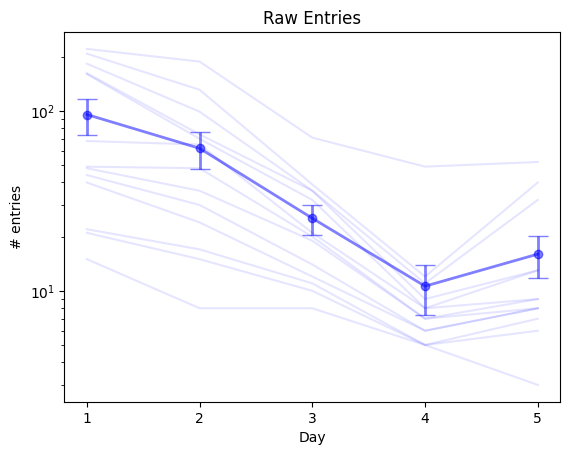

In [38]:
#@title Plot mean daily entries { form-width: "5%" }

# create 'learning' curve figure (using inner function):
# -------------------------------------------------------
# parameters:
individualLines=True
plotGeneralMean=False

# get the means and fill empty days with zero (in case participants entered following the experiment completion)
daysDataMean=days_data.mean(skipna=True)
daysDataSEM=days_data.sem(skipna=True)
for i in range(int(daysDataMean.index.max())):
  if i+1 not in daysDataMean.index:
    daysDataMean[float(i+1)]=0
    daysDataSEM[float(i+1)]=0
daysDataMean.sort_index()
daysDataSEM.sort_index()

shortTrainingMean=shortTraining.mean(skipna=True)
shortTrainingSEM=shortTraining.sem(skipna=True)
shortTrainingSTD=shortTraining.std(skipna=True)
for i in range(int(shortTrainingMean.index.max())):
  if i+1 not in shortTrainingMean.index or np.isnan(shortTrainingMean[float(i+1)]):
    shortTrainingMean[float(i+1)]=0
    shortTrainingSEM[float(i+1)]=0
    shortTrainingSTD[float(i+1)]=0
shortTrainingMean = shortTrainingMean.sort_index()
shortTrainingSEM = shortTrainingSEM.sort_index()
shortTrainingSTD = shortTrainingSTD.sort_index()


# plot
plt.figure()
if individualLines:  # create individual lines
    plt.plot(shortTraining.T, color='blue', alpha=0.1)

# mean lines
if plotGeneralMean:
  plt.errorbar(daysDataMean.index, daysDataMean, color='black', label='All', yerr=daysDataSEM, capsize=7, alpha=0.5, marker='o', linewidth=2)
plt.errorbar(shortTrainingMean.index, shortTrainingMean, color='blue', label='Short training', yerr=shortTrainingSEM, capsize=7, alpha=0.5, marker='o', linewidth=2)

plt.xlabel('Day')
plt.ylabel('# entries')
plt.title('Raw Entries')

plt.yscale('log')
plt.xticks(range(1,6))
plt.savefig('daily entries.png', dpi=300, format='png')
plt.show()


In [35]:
short_err2

array([[53.12363779, 21.7719827 , 10.4505517 ,  1.30631896,  2.17719827],
       [53.12363779, 21.7719827 , 10.4505517 ,  1.30631896,  2.17719827]])

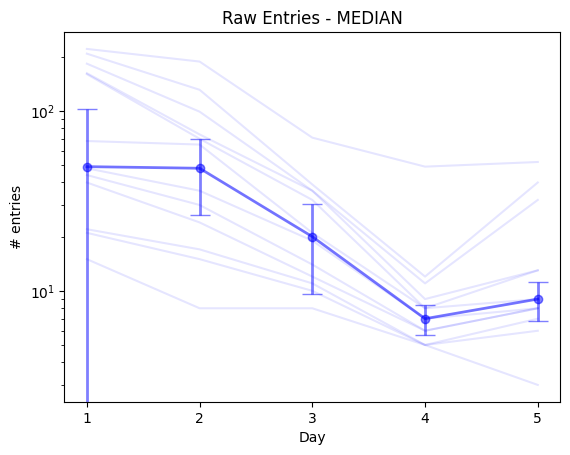

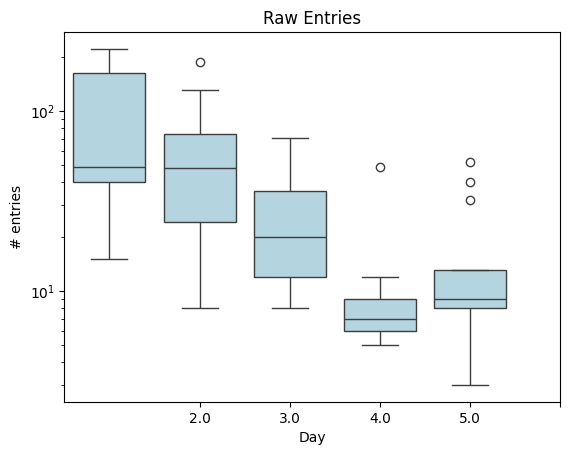

In [46]:
#@title Median with eror bars of 95% CIs (calculated like barplot notches) { form-width: "5%" }
total_entries_per_day = pd.DataFrame(data.sub_df.groupby(by=['subId', 'group', 'day']).size().unstack(fill_value=np.nan).stack()).rename(
    columns={0: 'n_entries'}).reset_index().pivot(index='subId', columns=['day'], values='n_entries')

# parameters:
days_data=total_entries_per_day
individualLines=True

shortTrainingMedian=shortTraining.median(skipna=True)
for i in range(int(shortTrainingMedian.index.max())):
  if i+1 not in shortTrainingMedian.index or np.isnan(shortTrainingMedian[float(i+1)]):
    shortTrainingMedian[float(i+1)]=0
shortTrainingMedian = shortTrainingMedian.sort_index()

# plot
plt.figure()
if individualLines:  # create individual lines
    plt.plot(shortTraining.T, color='blue', alpha=0.1)

shortCIs = shortTraining.values
shortCIs.sort(axis=0)
s_med95CIupper = np.median(shortCIs,axis=0) + 1.57 * (np.percentile(shortCIs,75,axis=0) - np.percentile(shortCIs,25,axis=0))/np.sqrt(shortCIs.shape[0])
s_med95CIlower = np.median(shortCIs,axis=0) - 1.57 * (np.percentile(shortCIs,75,axis=0) - np.percentile(shortCIs,25,axis=0))/np.sqrt(shortCIs.shape[0])

short_err = np.concatenate((np.array([s_med95CIlower]),np.array([s_med95CIupper])))
short_err2 = pd.concat([shortTrainingMedian-short_err[0,:], short_err[1,:]-shortTrainingMedian],axis=1).transpose().to_numpy()

plt.errorbar(shortTrainingMedian.index, shortTrainingMedian, color='blue', label='Short training', yerr=short_err2, capsize=7, alpha=0.5, marker='o', linewidth=2)

plt.xlabel('Day')
plt.ylabel('# entries')
plt.title('Raw Entries - MEDIAN')

plt.xticks(range(1,6))
plt.yscale('log')
plt.show()

# now plot with boxplot:
plt.figure()
sns.boxplot(data=shortTraining, color='lightblue')
plt.xlabel('Day')
plt.ylabel('# entries')
plt.title('Raw Entries')

plt.yscale('log')
plt.xticks(range(1,6))
plt.show()



In [96]:
import matplotlib.dates as mdates
import matplotlib.patches as patches
from matplotlib.patches import Patch

>>> Create a new data variable with times in common time (i.e., day one is set to same date etc.)
>>> Creating a dictionary with the relevant data.
>>> Subject 105 did not confirm the devaluation manipulation. | Taking the alert time instead (if possible), if not there will be an error.
>>> Subject 106 did not confirm the valued_again manipulation. | for future subjects maybe change to take the AlertTime, for now I just put 5:00


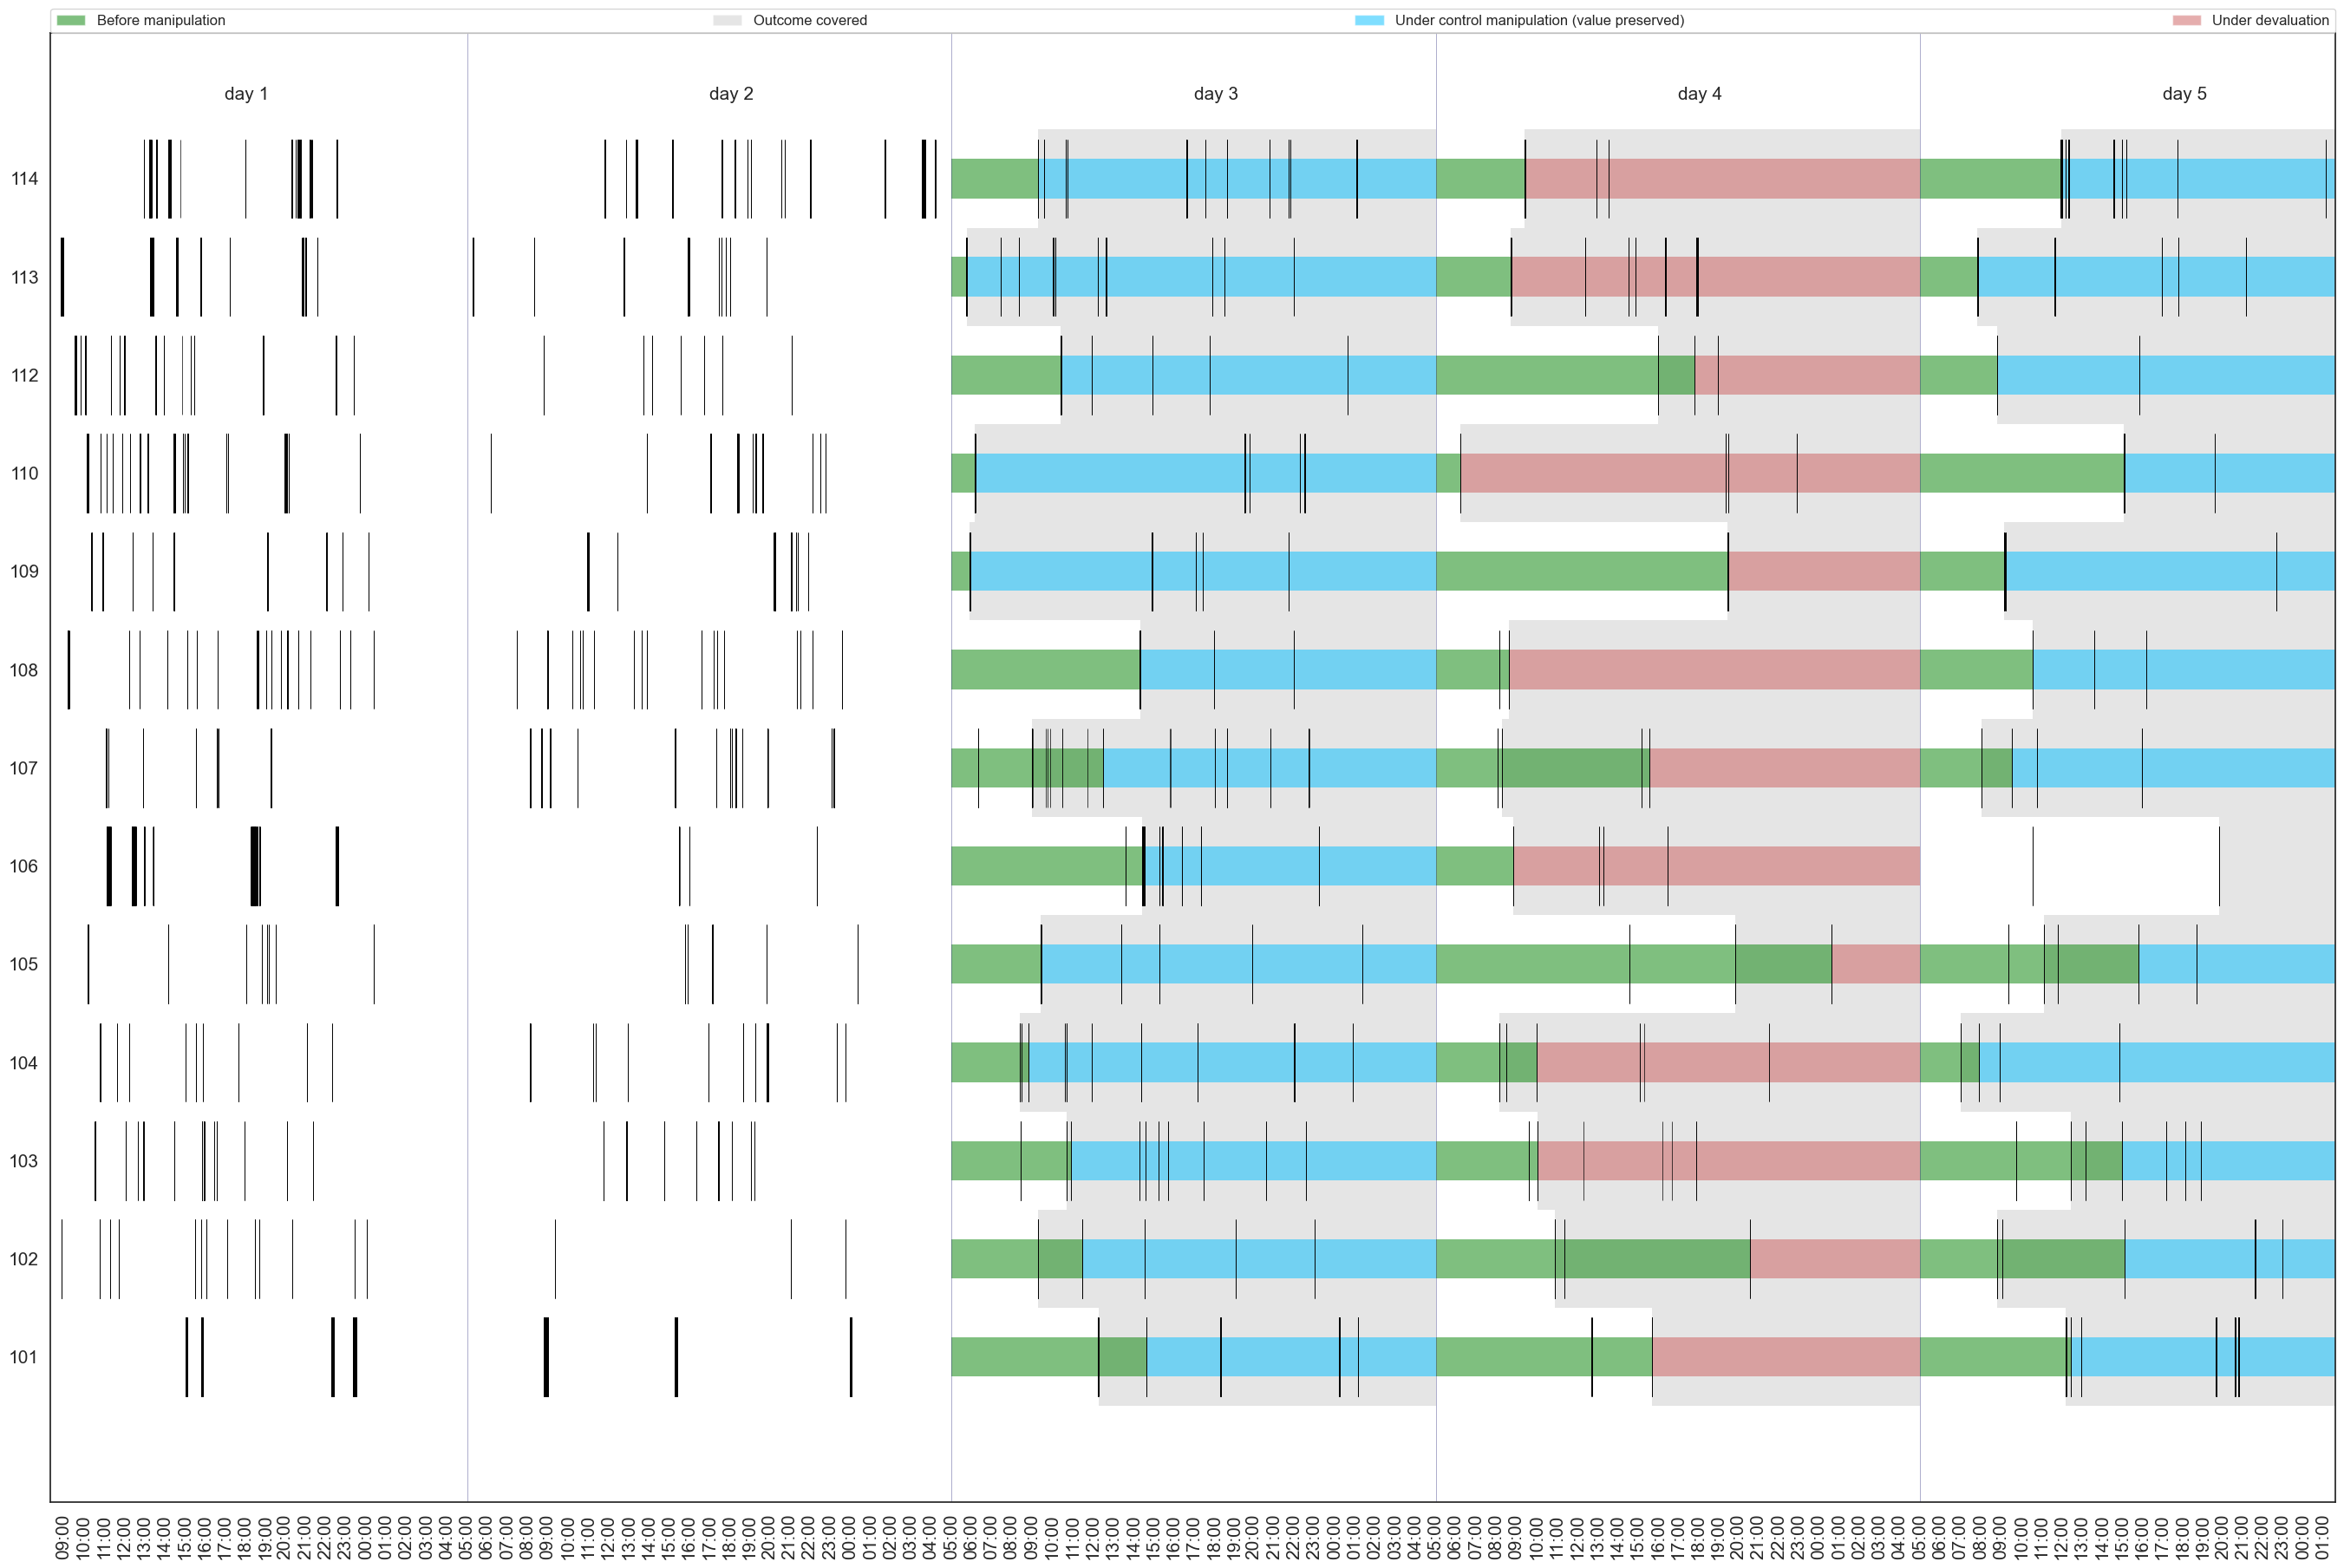

In [117]:
#@title event plots across all days { form-width: "5%" }
sns.set_theme(style="white")

def plotEvents(differentiatePressesByColor = True, differentiatePressesByLineHeight = True, showOnlyAlignedManipulationDays = False, figSize = (12,5), daysRange = (1,12)):
  '''
  This fucntion plot the events during the app in a given range or alternatively only of the manipulation days (when showOnlyAlignedManipulationDays = True).
  The range of the days shown is indicated in daysRange(first day, last day) in case showOnlyAlignedManipulationDays=False.
  It can use different colors to indicate whether the event is includes only entering, press once or pressed twice (when differentiatePressesByColor = True and/or differentiatePressesByLineHeight = False).
  * showOnlyAlignedManipulationDays = True daysRange is redundant.

  *** IMPORTANT ***
  To edit if necessary:
  In some cases additional editing of the legend is required
  '''
  # Parameters:
  # ------------------------
  # labels:
  xlabelFontSize = 15
  line_colors = [[1,0.8,0],[1,0.4,0],[1,0,0]] if differentiatePressesByColor else ['black'] * 3
  # colors:
  outcome_covered_color = {'color': 'gray', 'alpha': 0.2}
  before_manipulation_activated_color = {'color': 'green', 'alpha': 0.5}
  under_still_devalued_control_color = {'color': 'deepskyblue', 'alpha': 0.5}
  under_devaluation_color = {'color': 'indianred', 'alpha': 0.5}
  # event lines:
  linelengths = [0.4, 0.6, 0.8] if differentiatePressesByLineHeight else [0.8] * 3
  linewidth = 0.5
  # days range to present (if showOnlyAlignedManipulationDays=False)
  daysRange = (1,3) if showOnlyAlignedManipulationDays else daysRange
  # number of potential subject IDs in each group (i.e., every 100 or every 1000)
  potentialSubIdsPerGroup = 100

  # HANDLE DATA:
  # ------------------------
  # create a common time for all participants (using a mode starting date)
  print('>>> Create a new data variable with times in common time (i.e., day one is set to same date etc.)')
  commonTimeDF = data.sub_df.copy()
  # leave only subId<104:
  # commonTimeDF = commonTimeDF[commonTimeDF.subId<104]
  if showOnlyAlignedManipulationDays:
    commonTimeDF = commonTimeDF[(commonTimeDF['manipulationToday']=='still_valued') | (commonTimeDF['manipulationToday']=='devaluation') | (commonTimeDF['manipulationToday']=='still_valued_post_deval')]
    commonTimeDF.loc[commonTimeDF['manipulationToday']=='still_valued','day'] = 1
    commonTimeDF.loc[commonTimeDF['manipulationToday']=='devaluation','day'] = 2
    commonTimeDF.loc[commonTimeDF['manipulationToday']=='still_valued_post_deval','day'] = 3

  for timeVar in timeInStringColumns:
    commonTimeDF[timeVar] = commonTimeDF[timeVar].apply(lambda x: pd.to_datetime(x).replace(tzinfo=None))
    for i,x in enumerate(commonTimeDF[timeVar]):
      if not pd.isnull(x):
        try:
          commonTimeDF.iloc[i, commonTimeDF.columns.get_loc(timeVar)] = (x - timedelta(hours=dailyOffsetHours)).replace(year=2000,month=1,day=int(commonTimeDF.day.iloc[i])) + timedelta(hours=dailyOffsetHours)
        except Exception as e:
          print('>>> A problem in converting element ' + str(i) + ' in ' + str(timeVar) + ' of the specified time ' + str(x) + '.')
          print('>>> Error type: ' + str(e))


  subjects = commonTimeDF.subId.unique()
  n_subjects = len(subjects)
  lineoffsets = np.linspace(start=1, stop=n_subjects, num=n_subjects)

  # Create time dict of all subjects. The times extracted are the startTime in all cases.
  print('>>> Creating a dictionary with the relevant data.')
  timeDict = {}
  for sub in subjects:
    timeDict[sub] = {
        'startTime': commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.day>=daysRange[0]) & (commonTimeDF.day<=daysRange[1]) & (~commonTimeDF.startTime.isna())].startTime, #get when there was startTime
        'startTimeFollowedBy1Press': commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.day>=daysRange[0]) & (commonTimeDF.day<=daysRange[1]) & (~commonTimeDF.press1Time.isna())].startTime, #get when there was press1Time
        'startTimeFollowedBy2Presses': commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.day>=daysRange[0]) & (commonTimeDF.day<=daysRange[1]) & (~commonTimeDF.press2Time.isna())].startTime, #get when there was press2Time
        'cloudsStartTimes': [],
        'still_valued_indicationTrialEndTime': {'day': [], 'time': []},
        'devaluation_indicationTrialEndTime': {'day': [], 'time': []},
        'valued_AGAIN_indicationTrialEndTime': {'day': [], 'time': []},
    }
    for day in commonTimeDF.day.unique():
      if not commonTimeDF[(commonTimeDF.subId==sub) &(commonTimeDF.day==day) & (commonTimeDF.hideOutcome == True)].empty:
        timeDict[sub]['cloudsStartTimes'].append(commonTimeDF[(commonTimeDF.subId==sub) &(commonTimeDF.day==day) & (commonTimeDF.hideOutcome == True)].iloc[0].startTime)
    
    still_valued_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.activateManipulation==True) & (commonTimeDF.manipulationToday=='still_valued') & (~commonTimeDF.manipulationConfirmationTime.isnull())]
    timeDict[sub]['still_valued_indicationTrialEndTime']['time'] = still_valued_indicationTrialEndTime_row.manipulationConfirmationTime
    timeDict[sub]['still_valued_indicationTrialEndTime']['day'] = still_valued_indicationTrialEndTime_row.day

    devaluation_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.activateManipulation==True) & (commonTimeDF.manipulationToday=='devaluation') & (~commonTimeDF.manipulationConfirmationTime.isnull())]
    if devaluation_indicationTrialEndTime_row.empty:
      print('>>> Subject ' + str(sub) + ' did not confirm the devaluation manipulation. | Taking the alert time instead (if possible), if not there will be an error.')
      devaluation_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.activateManipulation==True) & (commonTimeDF.manipulationToday=='devaluation') & (~commonTimeDF.manipulationAlertTime.isnull())]
      timeDict[sub]['devaluation_indicationTrialEndTime']['time'] = devaluation_indicationTrialEndTime_row.manipulationAlertTime
    else:
      timeDict[sub]['devaluation_indicationTrialEndTime']['time'] = devaluation_indicationTrialEndTime_row.manipulationConfirmationTime
    timeDict[sub]['devaluation_indicationTrialEndTime']['day'] = devaluation_indicationTrialEndTime_row.day

    valued_AGAIN_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.activateManipulation==True) & (commonTimeDF.manipulationToday=='still_valued_post_deval') & (~commonTimeDF.manipulationConfirmationTime.isnull())]
    if valued_AGAIN_indicationTrialEndTime_row.empty:
      print('>>> Subject ' + str(sub) + ' did not confirm the valued_again manipulation. | for future subjects maybe change to take the AlertTime, for now I just put 5:00')
      valued_AGAIN_indicationTrialEndTime_row = commonTimeDF[(commonTimeDF.subId==sub) & (commonTimeDF.manipulationToday=='still_valued_post_deval')]
      valued_AGAIN_indicationTrialEndTime_row = valued_AGAIN_indicationTrialEndTime_row.iloc[[0]]
      timeDict[sub]['valued_AGAIN_indicationTrialEndTime']['time'] = valued_AGAIN_indicationTrialEndTime_row['startTime'].apply(lambda x: x.replace(hour=5, minute=0, second=0, microsecond=0))
    else:
      timeDict[sub]['valued_AGAIN_indicationTrialEndTime']['time'] = valued_AGAIN_indicationTrialEndTime_row.manipulationConfirmationTime
    timeDict[sub]['valued_AGAIN_indicationTrialEndTime']['day'] = valued_AGAIN_indicationTrialEndTime_row.day

  # CREATE THE PLOT:
  # ------------------------
  fig, axs = plt.subplots()
  # create a raster plot of app entries (including the their number of presses)
  for idx, sub in enumerate(timeDict.keys()):
    axs.eventplot(timeDict[sub]['startTime'], colors=line_colors[0], lineoffsets=lineoffsets[idx] - (linelengths[2]-linelengths[0])/2,
                        linelengths=linelengths[0], linewidths=linewidth)
    axs.eventplot(timeDict[sub]['startTimeFollowedBy1Press'], colors=line_colors[1], lineoffsets=lineoffsets[idx] - (linelengths[2]-linelengths[1])/2,
                        linelengths=linelengths[1], linewidths=linewidth)
    axs.eventplot(timeDict[sub]['startTimeFollowedBy2Presses'], colors=line_colors[2], lineoffsets=lineoffsets[idx],
                        linelengths=linelengths[2], linewidths=linewidth)

  plt.yticks(np.arange(1, n_subjects+1, step=1))
  axs.set_yticklabels(subjects, fontsize=15)

  axs.xaxis.set_major_locator(mdates.HourLocator(interval = 1))
  axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
  axs.set_xlim(left = min(commonTimeDF[commonTimeDF.day >= daysRange[0]].startTime) - timedelta(hours=0.5), right = max(commonTimeDF[commonTimeDF.day <= daysRange[1]].startTime) + timedelta(hours=0.5))
  plt.xticks(fontsize = xlabelFontSize)
  plt.setp(plt.gca().xaxis.get_majorticklabels(),
          'rotation', 90)

  # figure setup and drawing 
  fig.set_size_inches(figSize)
  fig.canvas.draw()
  xlim = axs.get_xlim()

  # indicate seperate days (with a seperating line) and get the relevant xticks values:
  endOfDayXTicks = []
  middleOfDayXTicks = []
  dayInd = daysRange[0]
  for xtick in axs.get_xticklabels():
    if xtick.get_text()=='05:00': # create seperating lines between days
      xtick_x_value = xtick.get_unitless_position()[0]
      axs.axvline(x=xtick_x_value, color = 'midnightblue', alpha=0.5, linewidth=0.5)
      endOfDayXTicks.append(xtick_x_value)
    elif xtick.get_text()=='17:00': # add days inside mini titles:
      if showOnlyAlignedManipulationDays:
        dayTitle = ['still-valued','devalued', 'valued again'][dayInd-1]
      else:
        dayTitle = 'day ' + str(dayInd)
      axs.text(xtick.get_unitless_position()[0], n_subjects+0.8,dayTitle,fontsize=15)
      dayInd+=1
      middleOfDayXTicks.append(xtick.get_unitless_position()[0])


  # add rectangles that indicate outcome hiding (clouds) and manipulation (before/after):
  for i, sub in enumerate(subjects):
    # place cloud rectangles:
    for hidingStartTime in timeDict[sub]['cloudsStartTimes']:
      x_position_of_hidingStartTime = mdates.date2num(hidingStartTime)
      if xlim[0] < x_position_of_hidingStartTime < xlim[1]: # check if in range of the plot 
        # Create a Rectangle patch
        rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_hidingStartTime][0] if [x for x in endOfDayXTicks if x >= x_position_of_hidingStartTime] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
        rectCloudy = patches.Rectangle((x_position_of_hidingStartTime, lineoffsets[i]-0.5), rectRightEndingPoint - x_position_of_hidingStartTime, 1,linewidth=1,edgecolor='none',facecolor=outcome_covered_color['color'], alpha=outcome_covered_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
        # Add the patch to the Axes
        axs.add_patch(rectCloudy)    
    # place manipulations - still valued:
    x_position_of_still_valued =  mdates.date2num(timeDict[sub]['still_valued_indicationTrialEndTime']['time'])[0]
    if (xlim[0] < x_position_of_still_valued < xlim[1]) & (x_position_of_still_valued.size > 0) : # check if in range of the plot & not empty
      rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_still_valued][0] if [x for x in endOfDayXTicks if x >= x_position_of_still_valued] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
      rectStillValued = patches.Rectangle((x_position_of_still_valued, lineoffsets[i]-0.2), rectRightEndingPoint - x_position_of_still_valued, 0.4,linewidth=0,edgecolor='none',facecolor=under_still_devalued_control_color['color'], alpha=under_still_devalued_control_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectStillValued)
      # add the beginning of the day until the manipulation
      rectLeftStartingPoint = [x for x in endOfDayXTicks if x <= x_position_of_still_valued][-1] if [x for x in endOfDayXTicks if x <= x_position_of_still_valued] else axs.get_xlim()[0] # end of the day or end of the figure if it's the last day
      rectStillValuedBefore = patches.Rectangle((rectLeftStartingPoint, lineoffsets[i]-0.2), x_position_of_still_valued - rectLeftStartingPoint, 0.4,linewidth=0,edgecolor='none',facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectStillValuedBefore)
    # place manipulations - devaluation:
    x_position_of_devaluation =  mdates.date2num(timeDict[sub]['devaluation_indicationTrialEndTime']['time'])[0]
    if (xlim[0] < x_position_of_devaluation < xlim[1]) & (x_position_of_devaluation.size > 0) : # check if in range of the plot & not empty
      rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_devaluation][0] if [x for x in endOfDayXTicks if x >= x_position_of_devaluation] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
      rectDevalued = patches.Rectangle((x_position_of_devaluation, lineoffsets[i]-0.2), rectRightEndingPoint - x_position_of_devaluation, 0.4,linewidth=0,edgecolor='none',facecolor=under_devaluation_color['color'], alpha=under_devaluation_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectDevalued)
      # add the beginning of the day until the manipulation
      rectLeftStartingPoint = [x for x in endOfDayXTicks if x <= x_position_of_devaluation][-1] if [x for x in endOfDayXTicks if x <= x_position_of_devaluation] else axs.get_xlim()[0] # end of the day or end of the figure if it's the last day
      rectDevaluedBefore = patches.Rectangle((rectLeftStartingPoint, lineoffsets[i]-0.2), x_position_of_devaluation - rectLeftStartingPoint, 0.4,linewidth=0,edgecolor='none',facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectDevaluedBefore)
    # place manipulations - still valued AGAIN:
    x_position_of_still_valued_again =  mdates.date2num(timeDict[sub]['valued_AGAIN_indicationTrialEndTime']['time'])[0]
    if (xlim[0] < x_position_of_still_valued_again < xlim[1]) & (x_position_of_still_valued_again.size > 0) : # check if in range of the plot & not empty
      rectRightEndingPoint = [x for x in endOfDayXTicks if x >= x_position_of_still_valued_again][0] if [x for x in endOfDayXTicks if x >= x_position_of_still_valued_again] else axs.get_xlim()[1] # end of the day or end of the figure if it's the last day
      rectStillValued = patches.Rectangle((x_position_of_still_valued_again, lineoffsets[i]-0.2), rectRightEndingPoint - x_position_of_still_valued_again, 0.4,linewidth=0,edgecolor='none',facecolor=under_still_devalued_control_color['color'], alpha=under_still_devalued_control_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectStillValued)
      # add the beginning of the day until the manipulation
      rectLeftStartingPoint = [x for x in endOfDayXTicks if x <= x_position_of_still_valued_again][-1] if [x for x in endOfDayXTicks if x <= x_position_of_still_valued_again] else axs.get_xlim()[0] # end of the day or end of the figure if it's the last day
      rectStillValuedBefore = patches.Rectangle((rectLeftStartingPoint, lineoffsets[i]-0.2), x_position_of_still_valued_again - rectLeftStartingPoint, 0.4,linewidth=0,edgecolor='none',facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'])  #patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
      axs.add_patch(rectStillValuedBefore)


  # handle legends:
  legend_elements = [Patch(facecolor=before_manipulation_activated_color['color'], alpha=before_manipulation_activated_color['alpha'], label='Before manipulation'),
                    Patch(facecolor=outcome_covered_color['color'], alpha=outcome_covered_color['alpha'], label='Outcome covered'),
                    Patch(facecolor=under_still_devalued_control_color['color'], alpha=under_still_devalued_control_color['alpha'], label='Under control manipulation (value preserved)'),
                    Patch(facecolor=under_devaluation_color['color'], alpha=under_devaluation_color['alpha'], label='Under devaluation')]
  axs.legend(handles=legend_elements, bbox_to_anchor=(0, 1.0, 1., 0.01), ncol=4, mode="expand", borderaxespad=0., fontsize=12)

  plt.show()
  return timeDict

timeDict=plotEvents(differentiatePressesByColor = False, differentiatePressesByLineHeight = False, showOnlyAlignedManipulationDays = False, figSize = (34,22), daysRange = (1,n_experimental_days))


In [ ]:
def get_segment_weighted_mean_stddev(sub_dfs, measures, weighting_factor):
    '''
    This function calculates the weighted mean and standard deviation for specified measures
    in a dictionary of DataFrames and returns a new DataFrame with these statistics.
    '''
    results = []
    for subj, sub_df in sub_dfs.items():
        result = {'subID': subj}
        for measure in measures:
            mean = np.average(sub_df[measure], weights=sub_df[weighting_factor])
            std_dev = np.sqrt(np.average((sub_df[measure] - mean)**2, weights=sub_df[weighting_factor]))
            result[f'{measure}'] = mean
            result[f'{measure}_std_dev'] = std_dev
        results.append(result)

    new_sub_df = pd.DataFrame(results)
    return new_sub_df

one_phys_measure_all = get_segment_weighted_mean_stddev(TEMP_all_period_segments, ['mean_TEMP'], 'n_data_points')
one_phys_measure_all = pd.merge(one_phys_measure_all, get_segment_weighted_mean_stddev(HR_n_Resp_all_period_segments, ['mean_HR', 'mean_resp'], 'n_data_points'), on='subID', how='outer')
# concatenate the two dataframes on subj:
one_phys_measure_all = pd.merge(one_phys_measure_all, get_segment_weighted_mean_stddev(EDA_all_period_segments, ['SCR_Peaks_N', 'SCR_Peaks_Amplitude_Mean', 'EDA_Tonic_Mean', 'EDA_Tonic_SD', 'EDA_Phasic_Mean', 'EDA_Phasic_SD', 'EDA_Sympathetic', 'EDA_SympatheticN', 'EDA_Autocorrelation'], 'n_data_points'), on='subID', how='outer')
one_phys_measure_all = pd.merge(one_phys_measure_all, get_segment_weighted_mean_stddev(HRV_all_period_segments, HRV_all_period_segments['101'].loc[:,'HRV_MeanNN':].columns, 'n_data_points'), on='subID', how='outer')

# Remove 108 HR (ie NaNs instead; consider also removing 'mean_resp'):
one_phys_measure_all.loc[one_phys_measure_all['subID'] == '108', ['mean_HR']] = np.nan
# remove 108:
one_phys_measure_all = one_phys_measure_all[one_phys_measure_all['subID'] != '108'].reset_index(drop=True)

# maybe checck more outlies...
# remove columns withh all NaNs:
one_phys_measure_all = one_phys_measure_all.dropna(axis=1, how='all')
one_phys_measure_all

,subID,mean_TEMP,mean_TEMP_std_dev,mean_HR,mean_HR_std_dev,mean_resp,mean_resp_std_dev,SCR_Peaks_N,SCR_Peaks_N_std_dev,SCR_Peaks_Amplitude_Mean,SCR_Peaks_Amplitude_Mean_std_dev,EDA_Tonic_Mean,EDA_Tonic_Mean_std_dev,EDA_Tonic_SD,EDA_Tonic_SD_std_dev,EDA_Phasic_Mean,EDA_Phasic_Mean_std_dev,EDA_Phasic_SD,EDA_Phasic_SD_std_dev,EDA_Sympathetic,EDA_Sympathetic_std_dev,EDA_SympatheticN,EDA_SympatheticN_std_dev,EDA_Autocorrelation,EDA_Autocorrelation_std_dev,HRV_MeanNN,HRV_MeanNN_std_dev,HRV_SDNN,HRV_SDNN_std_dev,HRV_SDANN1,HRV_SDANN1_std_dev,HRV_SDNNI1,HRV_SDNNI1_std_dev,HRV_SDANN2,HRV_SDANN2_std_dev,HRV_SDNNI2,HRV_SDNNI2_std_dev,HRV_RMSSD,HRV_RMSSD_std_dev,HRV_SDSD,HRV_SDSD_std_dev,HRV_CVNN,HRV_CVNN_std_dev,HRV_CVSD,HRV_CVSD_std_dev,HRV_MedianNN,HRV_MedianNN_std_dev,HRV_MadNN,HRV_MadNN_std_dev,HRV_MCVNN,HRV_MCVNN_std_dev,HRV_IQRNN,HRV_IQRNN_std_dev,HRV_SDRMSSD,HRV_SDRMSSD_std_dev,HRV_Prc20NN,HRV_Prc20NN_std_dev,HRV_Prc80NN,HRV_Prc80NN_std_dev,HRV_pNN50,HRV_pNN50_std_dev,HRV_pNN20,HRV_pNN20_std_dev,HRV_MinNN,HRV_MinNN_std_dev,HRV_MaxNN,HRV_MaxNN_std_dev,HRV_HTI,HRV_HTI_std_dev,HRV_TINN,HRV_TINN_std_dev,HRV_VLF,HRV_VLF_std_dev,HRV_LF,HRV_LF_std_dev,HRV_HF,HRV_HF_std_dev,HRV_VHF,HRV_VHF_std_dev,HRV_TP,HRV_TP_std_dev,HRV_LFHF,HRV_LFHF_std_dev,HRV_LFn,HRV_LFn_std_dev,HRV_HFn,HRV_HFn_std_dev,HRV_LnHF,HRV_LnHF_std_dev,HRV_SD1,HRV_SD1_std_dev,HRV_SD2,HRV_SD2_std_dev,HRV_SD1SD2,HRV_SD1SD2_std_dev,HRV_S,HRV_S_std_dev,HRV_CSI,HRV_CSI_std_dev,HRV_CVI,HRV_CVI_std_dev,HRV_CSI_Modified,HRV_CSI_Modified_std_dev,HRV_PIP,HRV_PIP_std_dev,HRV_IALS,HRV_IALS_std_dev,HRV_PSS,HRV_PSS_std_dev,HRV_PAS,HRV_PAS_std_dev,HRV_GI,HRV_GI_std_dev,HRV_SI,HRV_SI_std_dev,HRV_AI,HRV_AI_std_dev,HRV_PI,HRV_PI_std_dev,HRV_C1d,HRV_C1d_std_dev,HRV_C1a,HRV_C1a_std_dev,HRV_SD1d,HRV_SD1d_std_dev,HRV_SD1a,HRV_SD1a_std_dev,HRV_C2d,HRV_C2d_std_dev,HRV_C2a,HRV_C2a_std_dev,HRV_SD2d,HRV_SD2d_std_dev,HRV_SD2a,HRV_SD2a_std_dev,HRV_Cd,HRV_Cd_std_dev,HRV_Ca,HRV_Ca_std_dev,HRV_SDNNd,HRV_SDNNd_std_dev,HRV_SDNNa,HRV_SDNNa_std_dev,HRV_DFA_alpha1,HRV_DFA_alpha1_std_dev,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Width_std_dev,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Peak_std_dev,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Mean_std_dev,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Max_std_dev,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Delta_std_dev,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Asymmetry_std_dev,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Fluctuation_std_dev,HRV_MFDFA_alpha1_Increment,HRV_MFDFA_alpha1_Increment_std_dev,HRV_DFA_alpha2,HRV_DFA_alpha2_std_dev,HRV_MFDFA_alpha2_Width,HRV_MFDFA_alpha2_Width_std_dev,HRV_MFDFA_alpha2_Peak,HRV_MFDFA_alpha2_Peak_std_dev,HRV_MFDFA_alpha2_Mean,HRV_MFDFA_alpha2_Mean_std_dev,HRV_MFDFA_alpha2_Max,HRV_MFDFA_alpha2_Max_std_dev,HRV_MFDFA_alpha2_Delta,HRV_MFDFA_alpha2_Delta_std_dev,HRV_MFDFA_alpha2_Asymmetry,HRV_MFDFA_alpha2_Asymmetry_std_dev,HRV_MFDFA_alpha2_Fluctuation,HRV_MFDFA_alpha2_Fluctuation_std_dev,HRV_MFDFA_alpha2_Increment,HRV_MFDFA_alpha2_Increment_std_dev,HRV_ApEn,HRV_ApEn_std_dev,HRV_SampEn,HRV_SampEn_std_dev,HRV_ShanEn,HRV_ShanEn_std_dev,HRV_FuzzyEn,HRV_FuzzyEn_std_dev,HRV_MSEn,HRV_MSEn_std_dev,HRV_CMSEn,HRV_CMSEn_std_dev,HRV_RCMSEn,HRV_RCMSEn_std_dev,HRV_CD,HRV_CD_std_dev,HRV_HFD,HRV_HFD_std_dev,HRV_KFD,HRV_KFD_std_dev,HRV_LZC,HRV_LZC_std_dev
0,101,33.333450,1.061584,74.740809,7.162237,-0.000144,0.002164,189.093187,82.333116,0.104819,0.060818,0.578378,0.486529,0.678130,0.642651,1.674045e-06,1.026931e-05,0.013675,0.007746,0.000251,0.000235,0.008212,0.003975,0.996114,0.009892,884.895867,64.115559,84.321486,22.432980,50.431681,23.990986,61.011348,13.200675,45.946966,25.018255,64.632356,14.497882,62.621499,15.579910,62.635394,15.588137,0.095084,0.023970,0.070577,0.015660,886.405724,64.102268,71.388378,24.063604,0.080502,0.026899,96.210609,32.741330,1.376261,0.333804,825.419655,64.617498,947.622754,73.140107,21.948038,8.741376,55.782952,8.672829,444.258209,78.771564,1229.748216,59.802340,13.097668,3.550930,22.142245,88.246771,0.003100,0.003832,0.003038,0.00

# ________________________________

# FROM PREVIOUS FILE (SEE WHAT TO USE)

## Get basic devaluation measures

In [5]:
post_manip_actions = data.sub_df.copy()
post_manip_actions = post_manip_actions[(post_manip_actions.manipulationToday.notna()) & (post_manip_actions.isUnderManipulation)]
print('total slips:', post_manip_actions[post_manip_actions.manipulationToday == 'devaluation'].shape[0])
print('total slips - ENTER only:', post_manip_actions[(post_manip_actions.manipulationToday == 'devaluation') & (post_manip_actions.press1Time.isna())].shape[0])
print('total slips - ONE press only:', post_manip_actions[(post_manip_actions.manipulationToday == 'devaluation') & (post_manip_actions.press1Time.notna()) & (post_manip_actions.press2Time.isna())].shape[0])

# print('total slips - No outcomeTime:', post_manip_actions[(post_manip_actions.manipulationToday == 'devaluation') & (post_manip_actions.outcomeTime.isna())].shape[0])
# print('total slips - No EndTime:', post_manip_actions[(post_manip_actions.manipulationToday == 'devaluation') & (post_manip_actions.endTime.isna())].shape[0])


total slips: 70
total slips - ENTER only: 7
total slips - ONE press only: 1


In [6]:
groupingVars = ["subId", "group", "manipulationToday", "isUnderManipulation"]
print('** Grouping by:')
print(groupingVars)
# do the grouping:
groupedData = data.sub_df.groupby(by=groupingVars).size().unstack(fill_value=0).stack()
# change and set names
groupedData.index.names = ['subID', 'group', 'manipulation', 'time']
groupedData = groupedData.rename(index={False: 'pre', True: 'post'})
groupedData.name = 'n_entries'
print('** The data:')
# print(groupedData)
# groupedData.to_csv(main_path + coreTableRelativePath)
# print('** csv file saved to ' + coreTableRelativePath)
# data.core_table = pd.read_csv(StringIO(groupedData.to_csv()))
# return daat.core_table
# change setting to sow all rows:
pd.set_option('display.max_rows', None)

groupedData_df = groupedData.reset_index()
# z[z.time=='post'].n_entries.sum()
# groupedData_df



** Grouping by:
['subId', 'group', 'manipulationToday', 'isUnderManipulation']
** The data:


In [41]:
df_copy = data.sub_df.copy()
# change press1Time so that it is True if not nan and False if nan
df_copy['press1Time'] = df_copy['press1Time'].notna()
df_copy['press2Time'] = df_copy['press2Time'].notna()
df_copy['outcomeTime'] = df_copy['outcomeTime'].notna()
df_copy['endTime'] = df_copy['endTime'].notna()
for var in ['press1Time', 'press2Time', 'outcomeTime', 'endTime']:
    groupingVars = ["subId", "group", "manipulationToday", var, "isUnderManipulation"]
    # make sure there is 0 whereever there are no values:
    groupedDataDetailed = df_copy.groupby(by=groupingVars).size().unstack(fill_value=0).stack()
    # change the col names to  ['subID', 'group', 'manipulation', var, 'time']:
    groupedDataDetailed.index.names = ['subID', 'group', 'manipulation', var, 'time']
    groupedDataDetailed.name = 'n_entries_' + var
    groupedDataDetailed = groupedDataDetailed.reset_index()
    # # change only isUnderManipulation to pre and post:
    groupedDataDetailed['time'] = groupedDataDetailed['time'].map({False: 'pre', True: 'post'})
    # groupedDataDetailed
    # remove instances where the var is False:
    groupedDataDetailed = groupedDataDetailed[groupedDataDetailed[var]]

    # # Merge the last column from groupedDataDetailed to groupedData_df
    groupedData_df = pd.merge(groupedData_df, groupedDataDetailed[['subID', 'group', 'manipulation', 'time', 'n_entries_' + var]], on=['subID', 'group', 'manipulation', 'time'], how='left')
    # connect only the last column from groupedDataDetailed to groupedData_df, but make sure it is align wrt subId	group	manipulationToday isUnderManipulation:
# groupedData_df
groupedData_df
groupedData_df['only_entered'] = groupedData_df['n_entries'] - groupedData_df['n_entries_press1Time']
groupedData_df['pressed_only_first'] = groupedData_df['n_entries_press1Time'] - groupedData_df['n_entries_press2Time']
groupedData_df['pressed_all_seq'] = groupedData_df['n_entries_press2Time']
# now remove n_entries_press1Time	n_entries_press2Time	n_entries_outcomeTime	n_entries_endTime:
groupedData_df = groupedData_df.drop(columns=['n_entries_press1Time', 'n_entries_press2Time', 'n_entries_outcomeTime', 'n_entries_endTime'])
groupedData_df[groupedData_df.time=='post']

,subID,group,manipulation,time,n_entries,only_entered,pressed_only_first,pressed_all_seq
1,101,short_training,devaluation,post,0,0,0,0
3,101,short_training,still_valued,post,34,0,0,34
5,101,short_training,still_valued_post_deval,post,35,0,0,35
7,102,short_training,devaluation,post,0,0,0,0
9,102,short_training,still_valued,post,5,0,0,5
11,102,short_training,still_valued_post_deval,post,3,0,0,3
13,103,short_training,devaluation,post,6,6,0,0
15,103,short_training,still_valued,post,7,0,0,7
17,103,short_training,still_valued_post_deval,post,3,0,0,3
19,104,short_training,devaluation,post,3,1,1,1


In [42]:
coreDataFileName = '/data/extracted_data/core_table.csv'

data.create_core_table(coreTableRelativePath=coreDataFileName)

** Grouping by:
['subId', 'group', 'manipulationToday', 'isUnderManipulation']
** The data:
subID  group           manipulation             time
101    short_training  devaluation              pre      5
                                                post     0
                       still_valued             pre      5
                                                post    34
                       still_valued_post_deval  pre      5
                                                post    35
102    short_training  devaluation              pre      5
                                                post     0
                       still_valued             pre      5
                                                post     5
                       still_valued_post_deval  pre      5
                                                post     3
103    short_training  devaluation              pre      5
                                                post     6
                       still_

,subID,group,manipulation,time,n_entries
0,101,short_training,devaluation,pre,5
1,101,short_training,devaluation,post,0
2,101,short_training,still_valued,pre,5
3,101,short_training,still_valued,post,34
4,101,short_training,still_valued_post_deval,pre,5
5,101,short_training,still_valued_post_deval,post,35
6,102,short_training,devaluation,pre,5
7,102,short_training,devaluation,post,0
8,102,short_training,still_valued,pre,5
9,102,short_training,still_valued,post,5


In [59]:
# read the data:
dff = pd.read_csv(filteredDF_File, index_col=0)
dff

,subId,group,day,cost,reward,hideOutcome,manipulationToday,activateManipulation,isUnderManipulation,consumptionTest,coins_task_hits_count,coins_task_misses_count,coin_task_finish_status,startTime,press1Time,press2Time,outcomeTime,endTime,userExitOrUnloadTime,realGameBeginsAlertTime,realGameBeginsConfirmationTime,resetContainerAlertTime,resetContainerConfirmationTime,manipulationAlertTime,manipulationConfirmationTime,foundCaveAlertTime,foundCaveConfirmationTime,endExperimentAlertTime,dataLoadingTime,screenOrientationData,isDemo,endExperiment,uniqueEntryID
0,104,short_training,1.0,"[1, 1, 1]",0.0,NaN,NaN,False,False,False,NaN,NaN,NaN,2023-12-04 10:48:50.799000-08:00,2023-12-04 10:48:55.358000-08:00,2023-12-04 10:48:56.056000-08:00,2023-12-04 10:48:58.858000-08:00,2023-12-04 10:48:59.864000-08:00,2023-12-04 10:49:05.887000-08:00,2023-12-04 10:48:50.811000-08:00,2023-12-04 10:48:54.067000-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,"{'screenOrientationEvents': [], 'screenInitialOrientation': 'portrait'}",False,NaN,9.0
1,104,short_training,1.0,"[1, 1, 1]",20.0,False,NaN,False,False,False,NaN,NaN,NaN,2023-12-04 10:49:11.502000-08:00,2023-12-04 10:49:12.790000-08:00,2023-12-04 10:49:13.227000-08:00,2023-12-04 10:49:16.029000-08:00,2023-12-04 10:49:17.032000-08:00,2023-12-04 10:49:21.651000-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,"{'screenOrientationEvents': [], 'screenInitialOrientation': 'portrait'}",False,False,10.0
2,104,short_training,1.0,"[1, 1, 1]",20.0,False,NaN,False,False,False,NaN,NaN,NaN,2023-12-04 10:50:24.090000-08:00,2023-12-04 10:50:25.266000-08:00,2023-12-04 10:50:25.669000-08:00,2023-12-04 10:50:28.473000-08:00,2023-12-04 10:50:29.476000-08:00,2023-12-04 10:50:33.258000-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,"{'screenOrientationEvents': [], 'screenInitialOrientation': 'portrait'}",False,False,11.0
3,104,short_training,1.0,"[1, 1, 1]",0.0,False,NaN,False,False,False,NaN,NaN,NaN,2023-12-04 11:39:46.136000-08:00,2023-12-04 11:39:47.472000-08:00,2023-12-04 11:39:47.825000-08:00,2023-12-04 11:39:50.629000-08:00,2023-12-04 11:39:51.631000-08:00,2023-12-04 11:39:54.955000-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,"{'screenOrientationEvents': [], 'screenInitialOrientation': 'portrait'}",False,False,12.0
4,104,short_training,1.0,"[1, 1, 1]",0.0,False,NaN,False,False,False,NaN,NaN,NaN,2023-12-04 12:16:14.560000-08:00,2023-12-04 12:16:15.831000-08:00,2023-12-04 12:16:16.197000-08:00,2023-12-04 12:16:19.001000-08:00,2023-12-04 12:16:20.004000-08:00,2023-12-04 12:16:22.547000-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,"{'screenOrientationEvents': [], 'screenInitialOrientation': 'portrait'}",False,False,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2760,113,short_training,5.0,"[1, 1, 1]",0.0,True,still_valued_post_deval,False,True,False,NaN,NaN,NaN,2024-03-01 21:08:46.162000-08:00,2024-03-01 21:08:47.605000-08:00,2024-03-01 21:08:47.937000-08:00,2024-03-01 21:08:50.739000-08:00,2024-03-01 21:08:51.742000-08:00,2024-03-01 21:08:54.064000-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,"{'screenOrientationEvents': [], 'screenInitialOrientation': 'portrait'}",False,False,479.0
2761,113,short_training,5.0,"[1, 1, 1]",0.0,True,still_valued_post_deval,False,True,False,NaN,NaN,NaN,2024-03-01 21:08:54.571000-08:00,2024-03-01 21:08:55.784000-08:00,2024-03-01 21:08:56.069000-08:00,2024-03-01 21:08:58.872000-08:00,2024-03-01 21:08:59.875000-08:00,2024-03-01 21:09:01.908000-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,"{'screenOrientationEvents': [], 'screenInitialOrientation': 'portrait'}",False,False,480.0
2762,113,short_training,6.0,"[1, 1, 1]",0.0,False,NaN,False,False,False,NaN,NaN,NaN,2024-03-02 05:42:11.787000-08:00,2024-03-02 05:42:13.367000-08:00,2024-03-02 05:42:13.833000-08:00,NaN,NaN,2024-03-02 05:42:21.094000-08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,"{'screenOrientationEvents': [], 'screenInitialOrientation': 'p

In [44]:
#@title create core_data + Summary Stats
# ------- replacing the core_bar_plots method ---------

# initialize vars (tables):
groups = data.sub_df.group.unique()
# making the data ready for ploting:
core_data = data.core_table[data.core_table.time == 'post']
core_data = core_data.drop(columns='time')
core_data = core_data.set_index(['subID', 'group', 'manipulation'])


In [45]:
#@title Create a DF with columns of averaged still-valued manipulations (+Summary Stats) {form-width: "1%"}
# (one for the pre and post and one that includes all the relvant ones in the parallel group - i.e. 5 days)
# extract and organize
core_data_with_averaged_still_valued=core_data.unstack('manipulation')
core_data_with_averaged_still_valued.columns = core_data_with_averaged_still_valued.columns.droplevel()
# add new vars
core_data_with_averaged_still_valued['mean_still_valued'] = core_data_with_averaged_still_valued.loc[:,['still_valued', 'still_valued_post_deval']].mean(axis=1)
core_data_with_averaged_still_valued['mean_still_valued_all'] = core_data_with_averaged_still_valued.loc[:,['still_valued',	'still_valued_post_deval']].mean(axis=1, skipna=True)
# construct and arange to bein the same structure as core_data:
core_data_with_averaged_still_valued.reset_index().set_index(['subID', 'group']).stack('manipulation')
core_data_with_averaged_still_valued = core_data_with_averaged_still_valued.drop(columns=['still_valued',	'still_valued_post_deval'])
core_data_with_averaged_still_valued = core_data_with_averaged_still_valued.reset_index().set_index(['subID', 'group']).stack('manipulation').to_frame()
core_data_with_averaged_still_valued.columns = ['n_entries']


In [46]:
#@title Create a DF with columns of DIFFERENCE measures {form-width: "1%"}

core_data_with_diffs = core_data.unstack('manipulation')
core_data_with_diffs.columns = core_data_with_diffs.columns.droplevel()

# add vars:
# add mean valued data:
core_data_with_diffs['mean_still_valued'] = core_data_with_diffs.loc[:,['still_valued', 'still_valued_post_deval']].mean(axis=1)
core_data_with_diffs['mean_still_valued_all'] = core_data_with_diffs.loc[:,['still_valued',	'still_valued_post_deval']].mean(axis=1, skipna=True)
# add square root data (to give less weight for high values)
core_data_with_diffs['devaluation_SQRT'] = np.sqrt(core_data_with_diffs['devaluation'])
core_data_with_diffs['still_valued_SQRT'] = np.sqrt(core_data_with_diffs['still_valued'])
core_data_with_diffs['still_valued_post_deval_SQRT'] = np.sqrt(core_data_with_diffs['still_valued_post_deval'])
core_data_with_diffs['mean_still_valued_SQRT'] = np.sqrt(core_data_with_diffs['mean_still_valued'])
core_data_with_diffs['mean_still_valued_all_SQRT'] = np.sqrt(core_data_with_diffs['mean_still_valued_all'])

# add diff vars:
core_data_with_diffs['postVal_minus_deval'] = core_data_with_diffs.loc[:,['devaluation', 'still_valued_post_deval']].diff(axis=1).loc[:,'still_valued_post_deval']
core_data_with_diffs['stillVal_minus_deval'] = core_data_with_diffs.loc[:,['devaluation', 'still_valued']].diff(axis=1).loc[:,'still_valued']
core_data_with_diffs['stillVal_minus_postVal'] = core_data_with_diffs.loc[:,['still_valued_post_deval', 'still_valued']].diff(axis=1).loc[:,'still_valued']
core_data_with_diffs['preVal_relativeDiff_deval'] = core_data_with_diffs.apply(lambda x: (x['still_valued'] - x['devaluation'])/(x['devaluation'] + x['still_valued']), axis=1)
core_data_with_diffs['postVal_relativeDiff_deval'] = core_data_with_diffs.apply(lambda x: (x['still_valued_post_deval'] - x['devaluation'])/(x['devaluation'] + x['still_valued_post_deval']), axis=1)
core_data_with_diffs['preVal_relativeDiff_deval_SQRT'] = core_data_with_diffs.apply(lambda x: (x['still_valued_SQRT'] - x['devaluation_SQRT'])/(x['devaluation_SQRT'] + x['still_valued_SQRT']), axis=1)
core_data_with_diffs['postVal_relativeDiff_deval_SQRT'] = core_data_with_diffs.apply(lambda x: (x['still_valued_post_deval_SQRT'] - x['devaluation_SQRT'])/(x['devaluation_SQRT'] + x['still_valued_post_deval_SQRT']), axis=1)

core_data_with_diffs['meanVal_minus_deval'] = core_data_with_diffs.loc[:,['devaluation', 'mean_still_valued']].diff(axis=1).loc[:,'mean_still_valued']
core_data_with_diffs['meanAllVal_minus_deval'] = core_data_with_diffs.loc[:,['devaluation', 'mean_still_valued_all']].diff(axis=1).loc[:,'mean_still_valued_all']
core_data_with_diffs['meanVal_minus_deval_SQRT'] = core_data_with_diffs.loc[:,['devaluation_SQRT', 'mean_still_valued_SQRT']].diff(axis=1).loc[:,'mean_still_valued_SQRT']
core_data_with_diffs['meanAllVal_minus_deval_SQRT'] = core_data_with_diffs.loc[:,['devaluation_SQRT', 'mean_still_valued_all_SQRT']].diff(axis=1).loc[:,'mean_still_valued_all_SQRT']
core_data_with_diffs['meanVal_relativeDiff_deval'] = core_data_with_diffs.apply(lambda x: (x['mean_still_valued'] - x['devaluation'])/(x['devaluation'] + x['mean_still_valued']), axis=1)
core_data_with_diffs['meanAllVal_relativeDiff_deval'] = core_data_with_diffs.apply(lambda x: (x['mean_still_valued_all'] - x['devaluation'])/(x['devaluation'] + x['mean_still_valued_all']), axis=1)
core_data_with_diffs['meanVal_relativeDiff_deval_SQRT'] = core_data_with_diffs.apply(lambda x: (x['mean_still_valued_SQRT'] - x['devaluation_SQRT'])/(x['devaluation_SQRT'] + x['mean_still_valued_SQRT']), axis=1)
core_data_with_diffs['meanAllVal_relativeDiff_deval_SQRT'] = core_data_with_diffs.apply(lambda x: (x['mean_still_valued_all_SQRT'] - x['devaluation_SQRT'])/(x['devaluation_SQRT'] + x['mean_still_valued_all_SQRT']), axis=1)

core_data_with_diffs['prcChange_preToDeval'] = core_data_with_diffs.apply(lambda x: ((x['devaluation'] - x['still_valued'])/x['still_valued'])*100, axis=1)
core_data_with_diffs['prcChange_preToPost'] = core_data_with_diffs.apply(lambda x: ((x['still_valued_post_deval'] - x['still_valued'])/x['still_valued'])*100, axis=1)

core_data_with_diffs['preVal_relativeDiff_postVal'] = core_data_with_diffs.apply(lambda x: (x['still_valued'] - x['still_valued_post_deval'])/(x['still_valued_post_deval'] + x['still_valued']), axis=1)
core_data_with_diffs['preVal_relativeDiff_postVal_SQRT'] = core_data_with_diffs.apply(lambda x: (x['still_valued_SQRT'] - x['still_valued_post_deval_SQRT'])/(x['still_valued_post_deval_SQRT'] + x['still_valued_SQRT']), axis=1)

if input("Should RelativeDiff values for participants with 0 entries after all manipulatuions turned to 0 (rather than nan)? [y/N] ") == 'y':
  print('Turn these values to zeros')
  columnsWithRelativeDiff = core_data_with_diffs.columns[['relativeDiff' in x for x in core_data_with_diffs.columns]]
  for col in columnsWithRelativeDiff:
    print(core_data_with_diffs.loc[core_data_with_diffs[col].isna(),col])
    core_data_with_diffs.loc[core_data_with_diffs[col].isna(),col] = 0

#Assemble entries variability measures
# get number of entries in each day
total_entries_per_day = pd.DataFrame(data.sub_df.groupby(by=['subId', 'group', 'day']).size().unstack(fill_value=np.nan).stack()).rename(
    columns={0: 'n_entries'}).reset_index().pivot(index='subId', columns=['day'], values='n_entries')

# remove data for days that shoudn't be in the calculation
total_entries_per_day = total_entries_per_day.loc[:,:n_experimental_days+10]
print('\n\njust to see')
display(total_entries_per_day)
print('\nand this one is the one eventually formed')
total_entries_per_day = total_entries_per_day.loc[:,:n_experimental_days]
total_entries_per_day.loc[:,4] = None # devaluation day
total_entries_per_day.loc[:,(n_experimental_days+1):] = None
display(total_entries_per_day)

# add the relevant data
core_data_with_diffs = core_data_with_diffs.assign(STD_entriesAcrossNoDevalDays=total_entries_per_day.std(axis=1,skipna=True).values)
core_data_with_diffs = core_data_with_diffs.assign(SEM_entriesAcrossNoDevalDays=total_entries_per_day.sem(axis=1,skipna=True).values)

core_data_with_diffs = core_data_with_diffs.assign(NormedSTD_entriesAcrossNoDevalDays=total_entries_per_day.std(axis=1,skipna=True).values / total_entries_per_day.mean(axis=1,skipna=True).values)
core_data_with_diffs = core_data_with_diffs.assign(NormedVar_entriesAcrossNoDevalDays=total_entries_per_day.var(axis=1,skipna=True).values / total_entries_per_day.mean(axis=1,skipna=True).values)

# Add first day entries and entries throught the experiment
core_data_with_diffs = core_data_with_diffs.assign(firstDayEntries=total_entries_per_day[1].values)
core_data_with_diffs = core_data_with_diffs.assign(allEntries=total_entries_per_day.sum(axis=1,skipna=True).values)

# -------------------------- Adding similar stuff but after excluding all manipulation days: -----------------------------

# get number of entries in each day
total_entries_per_day2 = pd.DataFrame(data.sub_df.groupby(by=['subId', 'group', 'day']).size().unstack(fill_value=np.nan).stack()).rename(
    columns={0: 'n_entries'}).reset_index().pivot(index='subId', columns=['day'], values='n_entries')

# remove data for days that shoudn't be in the calculation
total_entries_per_day2 = total_entries_per_day2.loc[:,:5]
total_entries_per_day2.loc[:,3:] = None

# add the relevant data
core_data_with_diffs = core_data_with_diffs.assign(STD_entriesAcrossNoManipulationDays=total_entries_per_day2.std(axis=1,skipna=True).values)
core_data_with_diffs = core_data_with_diffs.assign(SEM_entriesAcrossNoManipulationDays=total_entries_per_day2.sem(axis=1,skipna=True).values)

core_data_with_diffs = core_data_with_diffs.assign(NormedSTD_entriesAcrossNoManipulationDays=total_entries_per_day2.std(axis=1,skipna=True).values / total_entries_per_day2.mean(axis=1,skipna=True).values)
core_data_with_diffs = core_data_with_diffs.assign(NormedVar_entriesAcrossNoManipulationDays=total_entries_per_day2.var(axis=1,skipna=True).values / total_entries_per_day2.mean(axis=1,skipna=True).values)

# Add first day entries and entries throught the experiment
core_data_with_diffs = core_data_with_diffs.assign(allEntriesAcrossNoManipulationDay=total_entries_per_day2.sum(axis=1,skipna=True).values)


Turn these values to zeros
Series([], Name: preVal_relativeDiff_deval, dtype: float64)
Series([], Name: postVal_relativeDiff_deval, dtype: float64)
Series([], Name: preVal_relativeDiff_deval_SQRT, dtype: float64)
Series([], Name: postVal_relativeDiff_deval_SQRT, dtype: float64)
Series([], Name: meanVal_relativeDiff_deval, dtype: float64)
Series([], Name: meanAllVal_relativeDiff_deval, dtype: float64)
Series([], Name: meanVal_relativeDiff_deval_SQRT, dtype: float64)
Series([], Name: meanAllVal_relativeDiff_deval_SQRT, dtype: float64)
Series([], Name: preVal_relativeDiff_postVal, dtype: float64)
Series([], Name: preVal_relativeDiff_postVal_SQRT, dtype: float64)


just to see


day,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,11.0,14.0
subId,,,,,,,,,,,
101,162.0,131.0,39.0,5.0,40.0,4.0,NaN,NaN,1.0,NaN,NaN
102,21.0,8.0,10.0,5.0,8.0,2.0,NaN,NaN,NaN,NaN,NaN
103,44.0,30.0,12.0,11.0,8.0,2.0,NaN,NaN,NaN,NaN,NaN
104,15.0,48.0,20.0,8.0,9.0,2.0,NaN,NaN,NaN,NaN,NaN
105,22.0,17.0,14.0,7.0,13.0,2.0,NaN,NaN,NaN,NaN,NaN
106,183.0,15.0,36.0,9.0,3.0,1.0,3.0,NaN,NaN,1.0,1.0
107,40.0,70.0,21.0,6.0,8.0,3.0,NaN,NaN,NaN,NaN,NaN
108,48.0,36.0,8.0,5.0,7.0,2.0,NaN,NaN,NaN,NaN,NaN
109,49.0,65.0,32.0,7.0,13.0,2.0,NaN,NaN,NaN,NaN,NaN



and this one is the one eventually formed


day,1.0,2.0,3.0,4.0,5.0
subId,,,,,
101,162.0,131.0,39.0,None,40.0
102,21.0,8.0,10.0,None,8.0
103,44.0,30.0,12.0,None,8.0
104,15.0,48.0,20.0,None,9.0
105,22.0,17.0,14.0,None,13.0
106,183.0,15.0,36.0,None,3.0
107,40.0,70.0,21.0,None,8.0
108,48.0,36.0,8.0,None,7.0
109,49.0,65.0,32.0,None,13.0


## Assemble data for ITI (self-fromed sessions) and RTs

In [47]:
#@title Assemble the ITI and RTs data { form-width: "5%" }

# parameters:
timeOfEntranceAnim = 800 # time in ms it should takes the sequence pressing screen to appear:

seperatingMicroSessionsTime = 300 # namely if there is 300 seconds apart between subsequent startTime's it will be considered a new session.
# helpers:
getSecsFunc = np.vectorize(lambda x: x.total_seconds())
# ------------------------------------------------------------------------------
# Create a new sub_df and add new measures:
sub_df_extended = data.sub_df.copy().sort_values(['subId','startTime']) # ******** TO MAKE SURE STARTTIMES ARE IN THE CORRECT ORDER
sub_df_extended = sub_df_extended[sub_df_extended.endExperiment!=True] # remove irrelevant days
sub_df_extended['deltaStartTime']=np.insert(np.diff(sub_df_extended.startTime),0,None) # add difference between startTime
sub_df_extended['deltaSecStartTime']=np.insert(getSecsFunc(np.diff(sub_df_extended.startTime)),0,None) # add difference between startTime
sub_df_extended['sessionsBeginning'] = False

for sub in sub_df_extended.subId.unique(): # set stuff for the beginning of each subject
  sub_df_extended.loc[(sub_df_extended.subId==sub).idxmax(), 'deltaStartTime'] = None
  sub_df_extended.loc[(sub_df_extended.subId==sub).idxmax(), 'deltaSecStartTime'] = None
  sub_df_extended.loc[(sub_df_extended.subId==sub).idxmax(), 'sessionsBeginning'] = True

sub_df_extended.loc[sub_df_extended.deltaSecStartTime > seperatingMicroSessionsTime , 'sessionsBeginning'] = True # Add session beginning (except for the ones on day beginning)

sub_df_extended['secsToPress1'] = sub_df_extended.apply(lambda x: (x.press1Time - (x.startTime + timedelta(milliseconds = x.dataLoadingTime) + timedelta(milliseconds = timeOfEntranceAnim))).total_seconds(), axis=1)
sub_df_extended['secsToPress2'] = sub_df_extended.apply(lambda x: (x.press2Time - x.press1Time).total_seconds(), axis=1)
sub_df_extended['secsToExitAfterOutcomeTime'] = sub_df_extended.apply(lambda x: (x.userExitOrUnloadTime - x.outcomeTime).total_seconds(), axis=1)

sub_df_extended['secsToPress2fromEntry'] = sub_df_extended.apply(lambda x: (x.press2Time - (x.startTime + timedelta(milliseconds = x.dataLoadingTime) + timedelta(milliseconds = timeOfEntranceAnim))).total_seconds(), axis=1)
sub_df_extended['secsToExitAfterOutcomeTimefromEntry'] = sub_df_extended.apply(lambda x: (x.userExitOrUnloadTime - (x.startTime + timedelta(milliseconds = x.dataLoadingTime) + timedelta(milliseconds = timeOfEntranceAnim))).total_seconds(), axis=1)


In [48]:
#@title Assemble a summary table of ITI and RTs data + per day tables { form-width: "5%" }

for i, sub in enumerate(sub_df_extended.subId.unique()):
  # Assemble data
  # --------------
  # get relevant days and calculate time differences between entries:
  sub_data = sub_df_extended[sub_df_extended.subId==sub]
  # Remove first entry from each to ignore the large time difference over night
  x = sub_data.copy()
  for day in x.day.unique():
    x = x.drop(index = x[x.day==day].index[0])

  # -------------- construct DFs of daily data of session --------------------
  sub_n_daily_sessions=(x[x.deltaSecStartTime>300].groupby(['subId','group','day']).count().deltaSecStartTime + 1).reset_index('day').astype({"day": int}).pivot(columns='day')
  sub_n_daily_sessions.columns = sub_n_daily_sessions.columns.droplevel(0)

  sub_n_daily_entries=(sub_data.groupby(['subId','group','day']).count().startTime).reset_index('day').astype({"day": int}).pivot(columns='day')
  sub_n_daily_entries.columns = sub_n_daily_entries.columns.droplevel(0)

  # -------------- Calculate and Add new important measures --------------------
  x_devalDropped = x[x.manipulationToday != 'devaluation']
  x_allManipulationsDropped = x[x.manipulationToday.isna()]

  # Define the number of session as a measure of entries that came after more than 5 minutes from the last entry:
  n_sessions = len(x_devalDropped.deltaSecStartTime[x_devalDropped.deltaSecStartTime>300]) + (n_experimental_days-1) # for the beginning of each day (except devaluation day);
  n_sessions_no_manipulations = len(x_allManipulationsDropped.deltaSecStartTime[x_allManipulationsDropped.deltaSecStartTime>300]) + (n_experimental_days-3) # for the beginning of each day (except manipulation days);

  # Define the average sessions per day
  averageSessionsPerDay = n_sessions/(n_experimental_days-1)
  averageSessionsPerDay_no_manipulations = n_sessions_no_manipulations/(n_experimental_days-3)

  # Define the average entries per session
  averageEntriesInSession = (len(x_devalDropped.deltaSecStartTime) + (n_experimental_days-1)) / n_sessions
  averageEntriesInSession_no_manipulations = (len(x_allManipulationsDropped.deltaSecStartTime) + (n_experimental_days-3)) / n_sessions_no_manipulations

  # Create a table with the different measures
  summaryTable = x_devalDropped.deltaSecStartTime.describe()
  summaryTable['MAD'] = stats.median_abs_deviation(x_devalDropped.deltaSecStartTime, nan_policy='omit')
  summaryTable['Skew'] = x_devalDropped.deltaSecStartTime.skew()
  summaryTable['NP_Skew'] = (summaryTable['mean'] - summaryTable['50%']) / summaryTable['std']
  summaryTable['Norm_spread'] = summaryTable['std'] / summaryTable['mean']
  summaryTable['n_sessions'] = n_sessions
  summaryTable['n_sessionsPerDay'] = averageSessionsPerDay
  summaryTable['avgSessionEntries'] = averageEntriesInSession
  summaryTable['n_sessions_no_manipulations'] = n_sessions_no_manipulations
  summaryTable['n_sessionsPerDay_no_manipulations'] = averageSessionsPerDay_no_manipulations
  summaryTable['avgSessionEntries_no_manipulations'] = averageEntriesInSession_no_manipulations

  # Add measures of number of session and number of entries per session for after each manipulation
  for manipulation in sub_data.manipulationToday.unique()[sub_data.manipulationToday.unique()!=None]:
    # sessions after manipulations
    postManpulationTrialsDeltaSec = x.deltaSecStartTime[(x.manipulationToday == manipulation) & (x.isUnderManipulation)]
    summaryTable['n_sessions_' + manipulation] = len(postManpulationTrialsDeltaSec[postManpulationTrialsDeltaSec>300]) + ((postManpulationTrialsDeltaSec.iloc[0]<300) if len(postManpulationTrialsDeltaSec) else 0) # The last term is to consider as a session entries right after the manipulation
    summaryTable['avgSessionEntries_' + manipulation] = len(postManpulationTrialsDeltaSec) / summaryTable['n_sessions_' + manipulation]

  # assemble within-trial time variables:
  # --------------------------------------------
  summaryTable['MEANsecsToPress1'] = sub_data.secsToPress1.mean()
  summaryTable['MEANsecsToPress2'] = sub_data.secsToPress2.mean()
  summaryTable['MEANsecsToExitAfterOutcomeTime'] = sub_data[(sub_data.activateManipulation != True) & (sub_data.secsToExitAfterOutcomeTime<=60)].secsToExitAfterOutcomeTime.mean() # the latter is to exclude unreasonably higher values
  summaryTable['MEANsecsToPress2fromEntry'] = sub_data.secsToPress2fromEntry.mean()
  summaryTable['MEANsecsToExitAfterOutcomeTimefromEntry'] = sub_data[(sub_data.activateManipulation != True) & (sub_data.secsToExitAfterOutcomeTime<=60)].secsToExitAfterOutcomeTimefromEntry.mean() # the latter is to exclude unreasonably higher values
  
  for manipulation in sub_data.manipulationToday.unique()[sub_data.manipulationToday.unique()!=None]:
    # get the same RT data but only for post manipulations
    relevantData = sub_data[(sub_data.manipulationToday == manipulation) & (sub_data.isUnderManipulation)]
    summaryTable['Manipulation_MEANsecsToPress1_' + manipulation] = relevantData.secsToPress1.mean()
    summaryTable['Manipulation_MEANsecsToPress2_' + manipulation] = relevantData.secsToPress2.mean()
    summaryTable['Manipulation_MEANsecsToExitAfterOutcomeTime_' + manipulation] = relevantData[relevantData.secsToExitAfterOutcomeTime<=60].secsToExitAfterOutcomeTime.mean() # the latter is to exclude unreasonably higher values
    summaryTable['Manipulation_MEANsecsToPress2fromEntry_' + manipulation] = relevantData.secsToPress2fromEntry.mean()
    summaryTable['Manipulation_MEANsecsToExitAfterOutcomeTimefromEntry_' + manipulation] = relevantData[relevantData.secsToExitAfterOutcomeTime<=60].secsToExitAfterOutcomeTimefromEntry.mean() # the latter is to exclude unreasonably higher values
    # get the same RT of the differences between before and after manipulations
    relevantData2 = sub_data[(sub_data.manipulationToday == manipulation) & (sub_data.isUnderManipulation==False)]
    summaryTable['After_minus_Before_Manipulation_MEANsecsToPress1_' + manipulation] = relevantData.secsToPress1.mean() - relevantData2.secsToPress1.mean()
    summaryTable['After_minus_Before_Manipulation_MEANsecsToPress2_' + manipulation] = relevantData.secsToPress2.mean() - relevantData2.secsToPress2.mean()
    summaryTable['After_minus_Before_Manipulation_MEANsecsToExitAfterOutcomeTime_' + manipulation] = relevantData[relevantData.secsToExitAfterOutcomeTime<=60].secsToExitAfterOutcomeTime.mean() - relevantData2[(relevantData2.activateManipulation != True) & (relevantData2.secsToExitAfterOutcomeTime<=60)].secsToExitAfterOutcomeTime.mean() # the latter is to exclude unreasonably higher values
    summaryTable['After_minus_Before_Manipulation_MEANsecsToPress2fromEntry_' + manipulation] = relevantData.secsToPress2fromEntry.mean() - relevantData2.secsToPress2fromEntry.mean()
    summaryTable['After_minus_Before_Manipulation_MEANsecsToExitAfterOutcomeTimefromEntry_' + manipulation] = relevantData[relevantData.secsToExitAfterOutcomeTime<=60].secsToExitAfterOutcomeTimefromEntry.mean() - relevantData2[(relevantData2.activateManipulation != True) & (relevantData2.secsToExitAfterOutcomeTime<=60)].secsToExitAfterOutcomeTimefromEntry.mean() # the latter is to exclude unreasonably higher values

  # get RT data per day
  for day in sub_data.day.unique():
    day = int(day)
    summaryTable['MEANsecsToPress1_day' + str(day)] = sub_data[sub_data.day==day].secsToPress1.mean()
    summaryTable['MEANsecsToPress2_day' + str(day)] = sub_data[sub_data.day==day].secsToPress2.mean()
    summaryTable['MEANsecsToExitAfterOutcomeTime_day' + str(day)] = sub_data[(sub_data.day==day) & (sub_data.activateManipulation != True) & (sub_data.secsToExitAfterOutcomeTime<=60)].secsToExitAfterOutcomeTime.mean() # the latter is to exclude unreasonably higher values
    summaryTable['MEANsecsToPress2fromEntry_day' + str(day)] = sub_data[sub_data.day==day].secsToPress2fromEntry.mean()
    summaryTable['MEANsecsToExitAfterOutcomeTimefromEntry_day' + str(day)] = sub_data[(sub_data.day==day) & (sub_data.activateManipulation != True) & (sub_data.secsToExitAfterOutcomeTime<=60)].secsToExitAfterOutcomeTimefromEntry.mean()


  # Gather delta's data together:
  summaryTable['subId'] = sub
  if i == 0:
    timeDeltaMeasures = summaryTable
    nSessionByDay = sub_n_daily_sessions
    nDailyEntries = sub_n_daily_entries
  else:
    timeDeltaMeasures = pd.concat([timeDeltaMeasures, summaryTable], axis=1)
    nSessionByDay = pd.concat([nSessionByDay, sub_n_daily_sessions])
    nDailyEntries = pd.concat([nDailyEntries, sub_n_daily_entries])

# group together subjects data
timeDeltaMeasures = timeDeltaMeasures.transpose().set_index('subId')
timeDeltaMeasures.index = timeDeltaMeasures.index.astype('int') # making the index int instead of float

# add 1s to relevant days with nan (which means that there was one session)
nSessionByDay = nSessionByDay.reset_index('group')
nDailyEntries = nDailyEntries.reset_index('group')

# handle subjects with only one session on all days
missing_subjects = list(sorted(set(sub_df_extended.subId.unique()) - set(nSessionByDay.index))) # this is for subjects who had only one session across all days.
for missed_sub in missing_subjects:
  rowToAdd = pd.DataFrame(np.nan, index=[missed_sub], columns=nSessionByDay.columns)
  rowToAdd.group = sub_df_extended[sub_df_extended.subId == missed_sub].group.iloc[0]
  rowToAdd.index.name = 'subId'
  nSessionByDay = pd.concat([nSessionByDay, rowToAdd]).sort_index()

for group in ['short_training']:
  for c in range(1,n_experimental_days+1):
    nSessionByDay.loc[(nSessionByDay.group==group) & (nSessionByDay[c].isna()),c] = 1
# Get the daily average entries per session
avgEntriesPerSessionByDay = nDailyEntries.copy()
avgEntriesPerSessionByDay.loc[:,[i for i in range(1,avgEntriesPerSessionByDay.columns[-1]+1)]] = avgEntriesPerSessionByDay.loc[:,[i for i in range(1,avgEntriesPerSessionByDay.columns[-1]+1)]] / nSessionByDay.loc[:,[i for i in range(1,nSessionByDay.columns[-1]+1)]]
avgEntriesPerSessionByDay


if input("Should avg. entries per session after manipulations turned to 0 instead of NA when there where no sessions? [y/N] ") == 'y':
  print('Turn these values to zeros')
  columnsWithManipulationsAvgSessionEntries = timeDeltaMeasures.columns[['avgSessionEntries_' in x for x in timeDeltaMeasures.columns]]
  for col in columnsWithManipulationsAvgSessionEntries:
    timeDeltaMeasures.loc[timeDeltaMeasures[col].isna(),col] = 0

print('\n********************************\n created: timeDeltaMeasures + nSessionByDay and avgEntriesPerSessionByDay tables\n********************************')
print('Note: for the n_sessions, averageSessionsPerDay, and averageEntriesInSession (one score per participants) the entire day of devaluation is excluded.')
print('Note: for the n_sessions_no_manipulations, averageSessionsPerDay_no_manipulations, and averageEntriesInSession_no_manipulations (one score per participants) the entire manipulations days are excluded.')

/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_82184/1349047272.py:54: RuntimeWarning: invalid value encountered in scalar divide
  summaryTable['avgSessionEntries_' + manipulation] = len(postManpulationTrialsDeltaSec) / summaryTable['n_sessions_' + manipulation]
/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_82184/1349047272.py:54: RuntimeWarning: invalid value encountered in scalar divide
  summaryTable['avgSessionEntries_' + manipulation] = len(postManpulationTrialsDeltaSec) / summaryTable['n_sessions_' + manipulation]
/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_82184/1349047272.py:54: RuntimeWarning: invalid value encountered in scalar divide
  summaryTable['avgSessionEntries_' + manipulation] = len(postManpulationTrialsDeltaSec) / summaryTable['n_sessions_' + manipulation]
/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_82184/1349047272.py:54: RuntimeWarning: invalid value encountered in scalar divide
  summaryTable['avgSessionEntr

Turn these values to zeros

********************************
 created: timeDeltaMeasures + nSessionByDay and avgEntriesPerSessionByDay tables
********************************
Note: for the n_sessions, averageSessionsPerDay, and averageEntriesInSession (one score per participants) the entire day of devaluation is excluded.
Note: for the n_sessions_no_manipulations, averageSessionsPerDay_no_manipulations, and averageEntriesInSession_no_manipulations (one score per participants) the entire manipulations days are excluded.


## Make a summary table of all data together

In [49]:
timeDeltaMeasures_temp = timeDeltaMeasures.copy()
timeDeltaMeasures_temp.columns = ['timeDelta_'+ x for x in timeDeltaMeasures_temp.columns]
timeDeltaMeasures_temp.index.name = 'subID'
timeDeltaMeasures_temp.columns.name = 'manipulation'
all_data_for_R = pd.concat([core_data_with_diffs.reset_index('group'), timeDeltaMeasures_temp], axis=1)
all_data_for_R = all_data_for_R.reset_index().set_index(['subID','group'])

In [50]:
#@title add n_session and avgSessionEntries diff measures { form-width: "5%" }

def add_session_diff_measures(table, entryMeasure):
  still_val_Measure = 'timeDelta_' + entryMeasure + '_still_valued'
  deval_Measure = 'timeDelta_' + entryMeasure + '_devaluation'
  still_val_post_deval_Measure = 'timeDelta_' + entryMeasure + '_still_valued_post_deval'

  # add vars:
  # add mean valued data:
  table['mean_' + still_val_Measure] = table.loc[:,[still_val_Measure, still_val_post_deval_Measure]].mean(axis=1)
  # add square root data (to give less weight for high values)
  table[deval_Measure + '_SQRT'] = np.sqrt(table[deval_Measure])
  table[still_val_Measure + '_SQRT'] = np.sqrt(table[still_val_Measure])
  table[still_val_post_deval_Measure + '_SQRT'] = np.sqrt(table[still_val_post_deval_Measure])
  table['mean_' + still_val_Measure + 'SQRT'] = np.sqrt(table['mean_' + still_val_Measure])

  # add diff vars:
  table[entryMeasure + '_postVal_minus_deval'] = table.loc[:,[deval_Measure, still_val_post_deval_Measure]].diff(axis=1).loc[:,still_val_post_deval_Measure]
  table[entryMeasure + '_stillVal_minus_deval'] = table.loc[:,[deval_Measure, still_val_Measure]].diff(axis=1).loc[:,still_val_Measure]
  table[entryMeasure + '_preVal_relativeDiff_deval'] = table.apply(lambda x: (x[still_val_Measure] - x[deval_Measure])/(x[deval_Measure] + x[still_val_Measure]) if (x[deval_Measure] + x[still_val_Measure]) != 0 else None, axis=1)
  table[entryMeasure + '_postVal_relativeDiff_deval'] = table.apply(lambda x: (x[still_val_post_deval_Measure] - x[deval_Measure])/(x[deval_Measure] + x[still_val_post_deval_Measure]) if (x[deval_Measure] + x[still_val_post_deval_Measure]) != 0 else None, axis=1)
  table[entryMeasure + '_preVal_relativeDiff_deval_SQRT'] = table.apply(lambda x: (x[still_val_Measure + '_SQRT'] - x[deval_Measure + '_SQRT'])/(x[deval_Measure + '_SQRT'] + x[still_val_Measure + '_SQRT']) if (x[deval_Measure + '_SQRT'] + x[still_val_Measure + '_SQRT']) != 0 else None, axis=1)
  table[entryMeasure + '_postVal_relativeDiff_deval_SQRT'] = table.apply(lambda x: (x[still_val_post_deval_Measure + '_SQRT'] - x[deval_Measure + '_SQRT'])/(x[deval_Measure + '_SQRT'] + x[still_val_post_deval_Measure + '_SQRT']) if (x[deval_Measure + '_SQRT'] + x[still_val_post_deval_Measure + '_SQRT']) != 0 else None, axis=1)

  table[entryMeasure + '_meanVal_minus_deval'] = table.loc[:,[deval_Measure, 'mean_' + still_val_Measure]].diff(axis=1).loc[:,'mean_' + still_val_Measure]
  table[entryMeasure + '_meanVal_minus_deval_SQRT'] = table.loc[:,[deval_Measure + '_SQRT', 'mean_' + still_val_Measure + 'SQRT']].diff(axis=1).loc[:,'mean_' + still_val_Measure + 'SQRT']
  table[entryMeasure + '_meanVal_relativeDiff_deval'] = table.apply(lambda x: (x['mean_' + still_val_Measure] - x[deval_Measure])/(x[deval_Measure] + x['mean_' + still_val_Measure]) if (x[deval_Measure] + x['mean_' + still_val_Measure]) != 0 else None, axis=1)
  table[entryMeasure + '_meanVal_relativeDiff_deval_SQRT'] = table.apply(lambda x: (x['mean_' + still_val_Measure + 'SQRT'] - x[deval_Measure + '_SQRT'])/(x[deval_Measure + '_SQRT'] + x['mean_' + still_val_Measure + 'SQRT']) if (x[deval_Measure + '_SQRT'] + x['mean_' + still_val_Measure + 'SQRT']) != 0 else None, axis=1)

  if input("Should RelativeDiff values for participants with 0 entries after all manipulatuions turned to 0 (rather than nan)? [y/N] ") == 'y':
    print('Turn these values to zeros')
    columnsWithRelativeDiff = table.columns[['relativeDiff' in x for x in table.columns]]
    for col in columnsWithRelativeDiff:
      table.loc[table[col].isna(),col] = 0

  table.tail()

  return table

all_data_for_R = add_session_diff_measures(table=all_data_for_R, entryMeasure = 'n_sessions')

all_data_for_R = add_session_diff_measures(table=all_data_for_R, entryMeasure = 'avgSessionEntries')

Turn these values to zeros
Turn these values to zeros


In [51]:
#@title { form-width: "5%" }
#@markdown Assemble and add entries variability measures for n_sessions and avgSessionEntries

# get number of entries in each day
n_sessions_by_day = nSessionByDay.drop(['group'],axis=1)
# remove data for days that shoudn't be in the calculation
n_sessions_by_day.loc[100:199, main_manipulation_days['short_training']['devaluation']] = None
n_sessions_by_day

# add the relevant data
all_data_for_R = all_data_for_R.assign(n_sessions_STD_entriesAcrossNoDevalDays=n_sessions_by_day.std(axis=1,skipna=True).values)
all_data_for_R = all_data_for_R.assign(n_sessions_SEM_entriesAcrossNoDevalDays=n_sessions_by_day.sem(axis=1,skipna=True).values)

all_data_for_R = all_data_for_R.assign(n_sessions_NormedSTD_entriesAcrossNoDevalDays=n_sessions_by_day.std(axis=1,skipna=True).values / n_sessions_by_day.mean(axis=1,skipna=True).values)
all_data_for_R = all_data_for_R.assign(n_sessions_NormedVar_entriesAcrossNoDevalDays=n_sessions_by_day.var(axis=1,skipna=True).values / n_sessions_by_day.mean(axis=1,skipna=True).values)

# Add first day entries and entries throught the experiment
all_data_for_R = all_data_for_R.assign(firstDaySessions=n_sessions_by_day[1].values)
all_data_for_R = all_data_for_R.assign(allSessions=n_sessions_by_day.sum(axis=1,skipna=True).values)

# ------------------------------------------------------------------------------

# get number of entries in each day
avgSessionEntries_by_day = avgEntriesPerSessionByDay.drop(['group'],axis=1)
# remove data for days that shoudn't be in the calculation
avgSessionEntries_by_day.loc[100:199,main_manipulation_days['short_training']['devaluation']] = None
avgSessionEntries_by_day

# add the relevant data
all_data_for_R = all_data_for_R.assign(avgSessionEntries_STD_entriesAcrossNoDevalDays=avgSessionEntries_by_day.std(axis=1,skipna=True).values)
all_data_for_R = all_data_for_R.assign(avgSessionEntries_SEM_entriesAcrossNoDevalDays=avgSessionEntries_by_day.sem(axis=1,skipna=True).values)

all_data_for_R = all_data_for_R.assign(avgSessionEntries_NormedSTD_entriesAcrossNoDevalDays=avgSessionEntries_by_day.std(axis=1,skipna=True).values / avgSessionEntries_by_day.mean(axis=1,skipna=True).values)
all_data_for_R = all_data_for_R.assign(avgSessionEntries_NormedVar_entriesAcrossNoDevalDays=avgSessionEntries_by_day.var(axis=1,skipna=True).values / avgSessionEntries_by_day.mean(axis=1,skipna=True).values)

# Add first day entries and entries throught the experiment
all_data_for_R = all_data_for_R.assign(firstDayAvgSessionEntries=avgSessionEntries_by_day[1].values)
all_data_for_R['allAvgSessionEntries'] = all_data_for_R['timeDelta_avgSessionEntries']




## Put data together

In [52]:
# add what's added to the core_data_with_diffs and then save
all_data_for_R = pd.concat([all_data_for_R, core_data_with_diffs.loc[:,~core_data_with_diffs.columns.isin(all_data_for_R.columns)]], axis=1)


# Consumption Test (note a manual fix in the code)

In [53]:
#@title parse Consumption Test Data (note one manual correction based on the raw data) { form-width: "5%" }
consumptionTestData = data.sub_df[(data.sub_df.consumptionTest==True) & (~data.sub_df['foundCaveConfirmationTime'].isnull())]
# drop(['touchData', 'screenOrientationData') if they are there:
if 'touchData' in consumptionTestData.columns:
  consumptionTestData = consumptionTestData.drop(columns=['touchData'], axis=1)
if 'screenOrientationData' in consumptionTestData.columns:
  consumptionTestData = consumptionTestData.drop(columns=['screenOrientationData'], axis=1)

# A specific MANUAL fix for when there was no coin_task_finish_status (but there is data) for one subject
problems = consumptionTestData[consumptionTestData.coin_task_finish_status.isna()]
if problems.subId.unique() == 233 and problems.day.unique() == 9:
  consumptionTestData.loc[consumptionTestData.coin_task_finish_status.isna(),'coin_task_finish_status'] = [{'finish_time': None, 'total_gold_collected': 13, 'total_presses': 13}]

consumptionTestData.loc[consumptionTestData.coins_task_misses_count.isnull(), 'coins_task_misses_count'] = 0  # turn back NaNs in of task misses to 0;
# the next line is a fix needed for when loading the data from a file (and not from the server)
consumptionTestData.coin_task_finish_status = consumptionTestData.coin_task_finish_status.map(lambda x: x if isinstance(x,dict) else json.loads(x.replace("'", '"')))
consumptionTestData['gold'] = consumptionTestData.coin_task_finish_status.map(lambda x: x['total_gold_collected'])
consumptionTestData['rocks'] = consumptionTestData.coin_task_finish_status.map(lambda x: x['total_presses'] - x['total_gold_collected']) - consumptionTestData['coins_task_misses_count']
consumptionTestData['misses'] = consumptionTestData['coins_task_misses_count']
consumptionTestData['completionTime'] = consumptionTestData.coin_task_finish_status.map(lambda x: x['finish_time'])

consumptionTestData = consumptionTestData[['subId','group','day','manipulationToday','gold','rocks','misses', 'completionTime']]
consumptionTestData = consumptionTestData.rename(columns={'manipulationToday': 'manipulation'})
consumptionTestData = consumptionTestData.reset_index()
consumptionTestData = consumptionTestData.drop(columns='index')

# Make sure in the other stuff they were enterd
print('n subjects:', len(consumptionTestData.subId.unique()))
print('n subjects with consumption test on devaluation:', len(consumptionTestData[consumptionTestData.manipulation=='devaluation'].subId.unique()))
print('n subjects with consumption test on still_valued:', len(consumptionTestData[consumptionTestData.manipulation=='still_valued'].subId.unique()))
print('n subjects with consumption test on still_valued_post_deval:', len(consumptionTestData[consumptionTestData.manipulation=='still_valued_post_deval'].subId.unique()))

# create a list of subjects that did not commit at all the cave on the devaluation days:
subsNotEntered = []
for sub in consumptionTestData.subId.unique():
  subGroup = consumptionTestData[consumptionTestData.subId == sub].group.iloc[0]
  for manip in manipulations_renamed[subGroup]:
    if consumptionTestData[(consumptionTestData.subId == sub) & (consumptionTestData.manipulation == manip)].empty:
      print(f'Adding 0 for: {sub} - {subGroup} - {manip}')
      newRow = {'subId': sub,	'group': subGroup,	'day': all_manipulation_days[subGroup][manip], 'manipulation':manip, 'gold':0,'rocks':0,'misses':	0,'completionTime': None}
      consumptionTestData = pd.concat([consumptionTestData, pd.DataFrame(newRow, index=[0])], ignore_index=True)
      if manip == 'devaluation':
        subsNotEntered.append(sub)

consumptionTestData = consumptionTestData.sort_values(by=['subId', 'day'])
consumptionTestData = consumptionTestData.reset_index(drop=True)

print('\n\nsubjects that did not committed the task on devaluation:', subsNotEntered)
print('pointed at the data as an entry with 0 gold.')


n subjects: 13
n subjects with consumption test on devaluation: 12
n subjects with consumption test on still_valued: 13
n subjects with consumption test on still_valued_post_deval: 12
Adding 0 for: 106 - short_training - still_valued_post_deval
Adding 0 for: 105 - short_training - devaluation


subjects that did not committed the task on devaluation: [105]
pointed at the data as an entry with 0 gold.


/var/folders/h_/4yn2bj6118x8bmpj49gssb440000gn/T/ipykernel_82184/104585333.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if problems.subId.unique() == 233 and problems.day.unique() == 9:


In [54]:
consumptionTestData

,subId,group,day,manipulation,gold,rocks,misses,completionTime
0,101,short_training,3.0,still_valued,15,0.0,0.0,2023-11-08 22:39:09.248000+00:00
1,101,short_training,4.0,devaluation,14,1.0,1.0,2023-11-09 23:44:24.964000+00:00
2,101,short_training,5.0,still_valued_post_deval,15,1.0,0.0,2023-11-10 20:27:24.485000+00:00
3,102,short_training,3.0,still_valued,15,0.0,0.0,2023-11-08 19:29:25.313000+00:00
4,102,short_training,4.0,devaluation,12,0.0,1.0,2023-11-10 04:33:27.989000+00:00
5,102,short_training,5.0,still_valued_post_deval,15,1.0,2.0,2023-11-10 23:07:17.737000+00:00
6,103,short_training,3.0,still_valued,15,0.0,1.0,2023-11-15 18:56:19.567000+00:00
7,103,short_training,4.0,devaluation,0,0.0,0.0,2023-11-16 18:02:05.781000+00:00
8,103,short_training,5.0,still_valued_post_deval,15,0.0,0.0,2023-11-17 23:00:43.370000+00:00
9,104,short_training,3.0,still_valued,15,0.0,2.0,2023-12-06 16:49:01.267000+00:00


In [55]:
#@title Check eligibility of consumption tests
for subID in data.sub_df.subId.unique():
  if subID not in consumptionTestData.subId.unique():
    print('>>> subject ' + str(subID) + ' has 0 completed consumption tests.')
for subID in consumptionTestData.subId.unique():
  if len(consumptionTestData[consumptionTestData.subId == subID]) == 1 :
    print('>>> subject ' + str(subID) + ' has only 1 completed consumption tests in ' + consumptionTestData[consumptionTestData.subId == subID].manipulation.iloc[0].upper() + '.')


### Add the consumption test data to the main data for variable and file

In [56]:
all_data_for_R2 = all_data_for_R.reset_index()

for index, row in consumptionTestData.iterrows():
  all_data_for_R2.loc[all_data_for_R2.subID == row['subId'], f"cave_gold_{row['manipulation']}"] = row['gold']

all_data_for_R = all_data_for_R2.set_index(['subID','group'])

all_data_for_R.to_csv(allDataFor_R_File)


# Save raw data - use only when need it because it initialize the data variable
* If run on Colab, the files formed here are formed on line and then should be downloaded.

In [57]:
#@markdown Save Raw Data { form-width: "5%" }

import pickle
# # Save raw data as a list
data_temp = Data() # instanciates and creates the data.raw
with open(rawDataAsListFile, 'w') as f:
    for item in data_temp.raw:
        f.write("%s\n" % item)

data_temp.filter_trials_data()  # creates data.trials_data
data_temp.create_sub_dict()  # creates data.sub_dict (defaulted to create it from data.trials_data)
# save raw data binary
a_file = open(rawDataAsBinaryFile, "wb")
pickle.dump(data_temp.sub_dict, a_file)
a_file.close()
